In [1]:
import pandas as pd
import numpy as np
import decoupler as dc
import seaborn as sns
import gseapy as gp
import matplotlib.pyplot as plt
import matplotlib
import json
import scipy as sp
from plot_lib import plot_bubbles, plot_enrich
from plotnine import ggsave
import scanpy as sc
%load_ext autoreload
%autoreload 2

In [2]:
#Okabe- Ito palette
pal = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

# define top and bottom colormaps 
top = plt.get_cmap('Oranges_r', 128) # r means reversed version
bottom = plt.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = matplotlib.colors.ListedColormap(newcolors, name='OrangeBlue')

In [3]:
color_pal = {}
for x in zip(["CollecTri", "M2Kb_K-562", "M2Kb_MCF-7", "M2Kb_HepG2", "M2Kb_GM-12878", "CA_K-562", "CA_MCF-7", "CA_HepG2", "CA_GM-12878"], 
             [pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]]):
    color_pal[x[0]] = matplotlib.colors.to_rgba(x[1])
    
cmap = matplotlib.colors.ListedColormap([pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]])
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}

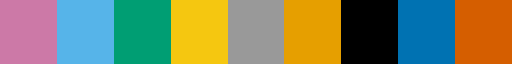

In [4]:
cmap

Network data loading

In [5]:
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [6]:
chip_atlas_k562 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_K562.tsv", sep="\t")

In [7]:
chip_atlas_k562.head()

,tf,Target_genes
0,ADNP,TRMT2A
1,ADNP,RANBP1
2,ADNP,OSCAR
3,ADNP,NDUFA3
4,ADNP,PSMD9


In [8]:
k562 = pd.read_table("../data/regulons/TF_target_mapping_filtered_merged_K562_with_ppi_with_dnase_with_atac_with_motifs_with_ccres_cleaned.tsv", sep="\t")

k562 = k562.loc[k562.is_M2Kb & (k562.is_pls | k562.is_pels | k562.is_dels), ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
k562 = k562.loc[k562.tf.isin(collectri.source) & k562.tf.isin(chip_atlas_k562.tf)]

In [9]:
chip_atlas_k562 = chip_atlas_k562.loc[chip_atlas_k562.tf.isin(k562.tf)]
chip_atlas_k562["weight"] = 1
k562["weight"] = 1

In [10]:
collectri = collectri[collectri.source.isin(k562.tf)]

### Prepare cosmic

In [11]:
COSMIC = dc.get_resource('CancerGeneCensus')

COSMIC.tumour_types_somatic = COSMIC.tumour_types_somatic.str.split(";")

COSMIC = COSMIC.explode("tumour_types_somatic")
cosmic_dict = {}
for typ in COSMIC.tumour_types_somatic.drop_duplicates():
    if COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.shape[0] > 1:
        cosmic_dict[typ] = COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.to_list()

# AML integrated dataset

### C6 healthy vs leukemic cells original

In [12]:
data = pd.read_csv("../data/case_study/c6_vs_other_leukemic_cells_aml_dataset.csv", sep=";", index_col=0)
data = data[data["n patients significant (consistent sign)"] > 0]
data

,n patients up,n patients down,Mean log2 Fold Change,SD log2 FC,Sum of log p values,n patients significant (consistent sign),Metadata: Takao & Kentsis LRC,Metadata: Velten
Gene,,,,,,,,
AREG,7,0,"2,3179424781",1,44,7,NaN,Other
FOS,7,0,"2,0089384569",1,42,7,NaN,AP1 factors
FTH1,7,0,"1,2502755149",1,60,7,NaN,Erythromyeloid priming
SLC40A1,7,0,"1,2451559941",1,47,7,1.0,Erythromyeloid priming
CD69,6,0,"1,0858648734",1,39,6,NaN,Other
...,...,...,...,...,...,...,...,...
ZSCAN18,1,0,"0,2772559810",0,8,1,1.0,Other
ZSCAN26,1,0,"0,9203504549",0,6,1,NaN,Other
ZSWIM6,1,0,"0,4332051269",0,8,1,NaN,Other


In [13]:
de_genes = data.loc[data["n patients significant (consistent sign)"] > 0]["Mean log2 Fold Change"].str.replace(",",'.').astype("float").to_frame()
de_genes.head()
de_genes["leukemic"] = de_genes["Mean log2 Fold Change"]
#de_genes = de_genes[de_genes["Mean log2 Fold Change"].abs() > 1]

In [14]:
de_genes

,Mean log2 Fold Change,leukemic
Gene,,
AREG,2.317942,2.317942
FOS,2.008938,2.008938
FTH1,1.250276,1.250276
SLC40A1,1.245156,1.245156
CD69,1.085865,1.085865
...,...,...
ZSCAN18,0.277256,0.277256
ZSCAN26,0.920350,0.920350
ZSWIM6,0.433205,0.433205


In [15]:
de_genes.describe()

,Mean log2 Fold Change,leukemic
count,3185.000000,3185.000000
mean,0.173994,0.173994
std,0.591406,0.591406
min,-2.251899,-2.251899
25%,-0.344875,-0.344875
50%,0.329855,0.329855
75%,0.542822,0.542822
max,2.651443,2.651443


In [16]:
de_genes["pval"] = np.exp(-data["Sum of log p values"] / 7)

In [17]:
de_genes

,Mean log2 Fold Change,leukemic,pval
Gene,,,
AREG,2.317942,2.317942,0.000151
FOS,2.008938,2.008938,0.000225
FTH1,1.250276,1.250276,0.000006
SLC40A1,1.245156,1.245156,0.000083
CD69,1.085865,1.085865,0.000410
...,...,...,...
ZSCAN18,0.277256,0.277256,0.201897
ZSCAN26,0.920350,0.920350,0.301194
ZSWIM6,0.433205,0.433205,0.201897


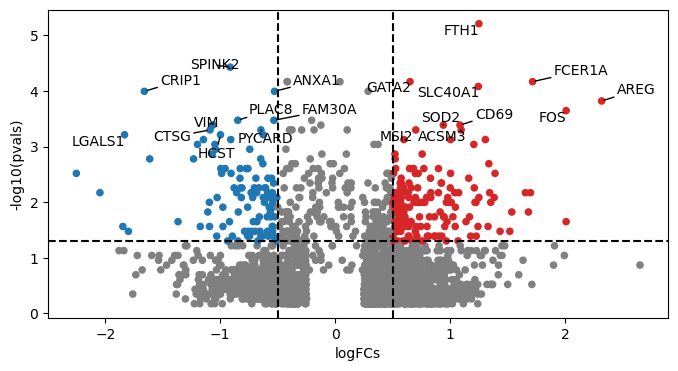

In [18]:
dc.plot_volcano_df(
    de_genes,
    x='Mean log2 Fold Change',
    y='pval',
    top=20,
    figsize=(8, 4)
)
plt.show()

In [19]:
#enr = gp.enrich(de_genes.loc[de_genes["leukemic"].abs() > 1, :].index.to_list(), "DisGeNET")
enr = gp.enrich(de_genes.index.to_list(), "DisGeNET")
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,"Leukemia, Myelocytic, Acute",446/1703,4.340686e-30,3.762073e-26,0,0,2.015400,136.260247,RB1;CDA;CHIC2;SPI1;TFRC;BACH1;GLS;GJA1;HOXA9;M...
1,DisGeNET,leukemia,491/1941,2.413857e-29,1.046045e-25,0,0,1.931294,127.260209,RB1;CDA;CHIC2;SPI1;RNH1;TFRC;EHMT1;SMC4;GLS;SM...
2,DisGeNET,Acute lymphocytic leukemia,265/907,4.159066e-25,1.201554e-21,0,0,2.286223,128.347040,RB1;IL1RN;SPI1;GFI1;JMJD1C;IKZF1;ACTB;GLS;LGAL...
3,DisGeNET,Precursor Cell Lymphoblastic Leukemia Lymphoma,192/618,1.124858e-21,2.437286e-18,0,0,2.467956,119.045868,RB1;IL1RN;CSF1;IRS1;MPG;GFI1;ATN1;F13A1;SLA;JM...
4,DisGeNET,"Liver Cirrhosis, Experimental",227/801,8.673278e-20,1.503426e-16,0,0,2.171344,95.303432,IFITM1;WIPF1;GMFG;ICAM2;ZDHHC2;GLS;SMC2;LGALS3...
...,...,...,...,...,...,...,...,...,...,...
8662,DisGeNET,Ragged-red muscle fibers,1/42,9.993174e-01,9.996634e-01,0,0,0.128493,0.000088,TYMP
8663,DisGeNET,Rat Adrenal Gland Pheochromocytoma,1/42,9.993174e-01,9.996634e-01,0,0,0.128493,0.000088,BCL2L1
8664,DisGeNET,Retinal Dystrophies,14/178,9.995380e-01,9.997687e-01,0,0,0.448258,0.000207,PEX16;HGSNAT;PRPS1;GRN;SUCNR1;TRAF3IP1;PRPF8;T...
8665,DisGeNET,Syndactyly,4/85,9.996806e-01,9.997960e-01,0,0,0.259783,0.000083,GJA1;NOG;LMNA;ZSWIM6


In [20]:
de_genes = pd.DataFrame(de_genes["leukemic"])

In [21]:
de_genes = de_genes.T

In [22]:
dc.check_corr(k562, mat=de_genes, source="tf", target="gene_symbol", weight=None).sort_values("corr")

,source1,source2,corr
7924,NONO,RBFOX2,-0.1903
9734,GTF2B,RBFOX2,-0.1658
11104,FUS,RBFOX2,-0.1493
12553,E2F1,GATAD2B,-0.1332
12612,ELF4,GATAD2B,-0.1325
...,...,...,...
4,DLX4,ZNF174,0.6143
3,CREM,NEUROD1,0.6224
2,JUND,NEUROD1,0.6382
1,CREM,JUND,0.7055


In [23]:
dc.check_corr(collectri, mat=de_genes, weight=None).sort_values("corr")

,source1,source2,corr
3726,MYC,SREBF1,-0.0648
4163,MYC,NCOR1,-0.0537
4354,MYC,TEAD1,-0.0493
4364,E2F6,SP1,-0.0491
4469,ESRRA,TP53,-0.0459
...,...,...,...
4,FOS,JUN,0.4750
3,CTNNB1,TCF7L2,0.5005
2,NFYA,NFYB,0.5345
1,SMAD2,SMAD3,0.5476


In [24]:
aml_disreg_enrich = pd.DataFrame()
aml_omim_enrich = pd.DataFrame()
aml_cosmic_enrich = pd.DataFrame()
megaheat = pd.DataFrame()

In [25]:
de_genes

Gene,AREG,FOS,FTH1,SLC40A1,CD69,CD99,CRIP1,FCER1A,LST1,VIM,...,ZNRF1,ZNRF3,ZPR1,ZRANB2,ZSCAN16-AS1,ZSCAN18,ZSCAN26,ZSWIM6,ZXDA,ZYX
leukemic,2.317942,2.008938,1.250276,1.245156,1.085865,-1.146033,-1.660485,1.716856,-0.68972,-1.063622,...,0.666956,0.495611,0.302954,0.565215,-0.624069,0.277256,0.92035,0.433205,0.862397,-0.539054


K562

In [26]:
tf_acts_k562, tf_pvals_k562= dc.run_ulm(de_genes, k562, source='tf', target='gene_symbol', weight="weight")

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [27]:
mask = tf_pvals_k562 < 0.05
active_tfs_k562 = tf_acts_k562.loc["leukemic", pd.DataFrame(tf_acts_k562 * mask).sum(axis=0) != 0].index.to_list()

In [28]:
active_tfs_k562

['ATF1',
 'ATF2',
 'BHLHE40',
 'CC2D1A',
 'CREB1',
 'CTCF',
 'E2F1',
 'ETS1',
 'FOXM1',
 'GATA2',
 'HDAC1',
 'IRF1',
 'KAT2B',
 'KLF16',
 'MNT',
 'NFATC3',
 'NR3C1',
 'PHF8',
 'PLAG1',
 'PML',
 'REST',
 'SAP30',
 'SIN3A',
 'TRIM28',
 'ZBTB7A',
 'ZNF77']

In [29]:
tf_acts_k562.index = ["score"]
tf_pvals_k562.index = ["p_value"]
out_k562 = pd.merge(left=tf_acts_k562.T, right=tf_pvals_k562.T, left_index=True, right_index=True)
out_k562.to_csv("../data/3-tf_activity/aml_k562_activity_m2kb.tsv", sep="\t", index=False)

In [30]:
out_k562.sort_values("p_value")

,score,p_value
PHF8,2.682597,0.007343
PLAG1,2.665130,0.007735
CC2D1A,2.640053,0.008330
E2F1,2.593962,0.009531
TRIM28,2.587372,0.009715
...,...,...
MXI1,0.032668,0.973942
ZNF239,0.024255,0.980651
ZNF79,0.019604,0.984360
LEF1,-0.005880,0.995309


In [31]:
active_tfs_k562

['ATF1',
 'ATF2',
 'BHLHE40',
 'CC2D1A',
 'CREB1',
 'CTCF',
 'E2F1',
 'ETS1',
 'FOXM1',
 'GATA2',
 'HDAC1',
 'IRF1',
 'KAT2B',
 'KLF16',
 'MNT',
 'NFATC3',
 'NR3C1',
 'PHF8',
 'PLAG1',
 'PML',
 'REST',
 'SAP30',
 'SIN3A',
 'TRIM28',
 'ZBTB7A',
 'ZNF77']

In [32]:
enr = gp.enrich(active_tfs_k562, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [33]:
enr = gp.enrich(active_tfs_k562, "DisGeNET")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [34]:
try:
    enr = gp.enrich(gene_list=active_tfs_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [35]:
heat = pd.concat([tf_acts_k562.rename({"leukemic": "score"}), tf_pvals_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "M2Kb_K-562"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,0.615055,0.538562,M2Kb_K-562
ARHGAP35,0.786835,0.431437,M2Kb_K-562
ARID1B,-0.365251,0.714948,M2Kb_K-562
ARID3A,1.163573,0.244684,M2Kb_K-562
ARID3B,0.421457,0.673450,M2Kb_K-562
...,...,...,...
ZNF436,0.108354,0.913722,M2Kb_K-562
ZNF444,-0.622665,0.533549,M2Kb_K-562
ZNF76,-0.936015,0.349337,M2Kb_K-562
ZNF77,2.009989,0.044517,M2Kb_K-562


CollecTri

In [36]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri, weight="weight")
#tf_pvals_ctri.loc["leukemic"] = fdrcorrection(tf_pvals_ctri.T["leukemic"])[1]

In [37]:
mask_ctri = tf_pvals_ctri < 0.05
active_tfs_ctri = tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].index.to_list()
tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].sort_values()

SPI1     -4.202702
ELF1     -3.954784
SP1      -3.776416
HEY1     -3.339543
RFX5     -2.920896
CREM     -2.515737
CTNNB1   -2.487155
IRF1     -2.360886
CREBBP   -2.335270
IKZF1    -2.294379
LEF1     -2.165952
NR3C1    -2.050395
IRF2     -2.034342
GATA2     2.048440
ELK1      2.460927
CREB1     2.501038
NFATC3    2.573544
E2F1      2.590117
KLF1      2.627798
NFIC      2.653232
NFE2      2.893968
EZH2      2.955058
Name: leukemic, dtype: float32

In [38]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/aml_k562_activity_collectri.tsv", sep="\t", index=False)

In [39]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_collectri_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [40]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_collectri_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [41]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network
0,DisGeNET,"Leukemia, Myelocytic, Acute",15/1703,8.115910e-12,1.262024e-08,0,0,23.218517,592.935797,CREBBP;SPI1;LEF1;IKZF1;GATA2;NR3C1;ELK1;KLF1;E...,CollecTri
1,DisGeNET,leukemia,15/1941,5.343432e-11,4.154518e-08,0,0,20.084557,475.051353,CREBBP;SPI1;LEF1;NFATC3;IKZF1;GATA2;NR3C1;KLF1...,CollecTri
2,DisGeNET,"Lupus Erythematosus, Systemic",12/1113,3.201825e-10,1.659613e-07,0,0,20.574387,449.799919,CREBBP;ELF1;SPI1;CREB1;SP1;IRF1;IRF2;CREM;IKZF...,CollecTri
3,DisGeNET,Central neuroblastoma,13/1655,1.991299e-09,7.729861e-07,0,0,16.129923,323.154596,CREBBP;CREM;GATA2;NR3C1;ELK1;CREB1;SP1;IRF1;NF...,CollecTri
4,DisGeNET,Neuroblastoma,13/1698,2.729257e-09,7.729861e-07,0,0,15.681438,309.225975,CREBBP;CREM;GATA2;NR3C1;ELK1;CREB1;SP1;IRF1;NF...,CollecTri
...,...,...,...,...,...,...,...,...,...,...,...
1550,DisGeNET,Arthritis,1/630,5.056562e-01,5.069603e-01,0,0,1.464835,0.998868,NR3C1,CollecTri
1551,DisGeNET,Kidney Diseases,1/639,5.106875e-01,5.116747e-01,0,0,1.443499,0.970028,CREBBP,CollecTri
1552,DisGeNET,Amyotrophic Lateral Sclerosis,1/660,5.222378e-01,5.229104e-01,0,0,1.395982,0.906875,CREBBP,CollecTri
1553,DisGeNET,Liver Cirrhosis,1/683,5.345894e-01,5.349335e-01,0,0,1.347298,0.843754,CTNNB1,CollecTri


In [42]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_collectri_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [43]:
heat = pd.concat([tf_acts_ctri.rename({"leukemic": "score"}), tf_pvals_ctri.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,0.615055,0.538562,M2Kb_K-562
ARHGAP35,0.786835,0.431437,M2Kb_K-562
ARID1B,-0.365251,0.714948,M2Kb_K-562
ARID3A,1.163573,0.244684,M2Kb_K-562
ARID3B,0.421457,0.673450,M2Kb_K-562
...,...,...,...
YBX3,-0.825308,0.409259,CollecTri
YY1,-1.443798,0.148894,CollecTri
ZBED1,0.299977,0.764214,CollecTri
ZBTB7A,-0.377502,0.705826,CollecTri


chip_atlas_k562

In [44]:
tf_acts_chip_atlas_k562, tf_pvals_chip_atlas_k562 = dc.run_ulm(de_genes, chip_atlas_k562.drop_duplicates(), source='tf', target='Target_genes', weight="weight")

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [45]:
tf_pvals_chip_atlas_k562

,ADNP,ARHGAP35,ARID1B,ARID3A,ARID3B,ARNT,ASH1L,ATF1,ATF2,ATF3,...,ZNF274,ZNF281,ZNF316,ZNF384,ZNF395,ZNF436,ZNF444,ZNF76,ZNF77,ZNF79
leukemic,0.474575,0.917271,0.525063,0.127674,0.615401,0.276648,0.995348,0.035705,0.002523,0.1869,...,0.344477,0.145598,0.456509,0.418333,0.110102,0.215864,0.842052,0.702109,0.719365,0.11751


In [46]:
mask_chip_atlas_k562 = tf_pvals_chip_atlas_k562 < 0.05

active_tfs_chip_atlas_k562 = tf_acts_chip_atlas_k562.loc["leukemic", pd.DataFrame(tf_acts_chip_atlas_k562 * mask_chip_atlas_k562).sum(axis=0) != 0].index.to_list()

In [47]:
tf_acts_chip_atlas_k562.index = ["score"]
tf_pvals_chip_atlas_k562.index = ["p_value"]
out_chip_atlas = pd.merge(left=tf_acts_chip_atlas_k562.T, right=tf_pvals_chip_atlas_k562.T, left_index=True, right_index=True)
out_chip_atlas.to_csv("../data/3-tf_activity/aml_k562_activity_ca_k562.tsv", sep="\t", index=False)

In [48]:
active_tfs_chip_atlas_k562

['ATF1',
 'ATF2',
 'ATF7',
 'BCLAF1',
 'BHLHE40',
 'BRD4',
 'CREB1',
 'CREM',
 'E2F1',
 'E2F4',
 'EGR1',
 'ERG',
 'ETS1',
 'FOXJ2',
 'FOXK2',
 'FOXM1',
 'GABPA',
 'GATA1',
 'GMEB1',
 'HCFC1',
 'HDAC1',
 'HEY1',
 'IKZF1',
 'IRF1',
 'JUN',
 'JUND',
 'KDM5B',
 'LDB1',
 'MAX',
 'MAZ',
 'MBD2',
 'MNT',
 'MTA3',
 'MYC',
 'NCOR1',
 'PBX2',
 'PHF8',
 'PML',
 'RBFOX2',
 'RCOR1',
 'REST',
 'RREB1',
 'SIN3A',
 'SMAD1',
 'SMAD5',
 'TAF1',
 'TBL1XR1',
 'TBP',
 'TCF12',
 'TCF3',
 'TCF7',
 'TFDP1',
 'UBTF',
 'USF1',
 'YY1',
 'ZBTB12',
 'ZBTB7A',
 'ZFX',
 'ZNF148']

In [49]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "OMIM_Expanded")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_ca_k562_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [50]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "DisGeNET")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_ca_k562_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)


In [51]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_ca_k562_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [52]:
heat = pd.concat([tf_acts_chip_atlas_k562.rename({"leukemic": "score"}), tf_pvals_chip_atlas_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "CA_K-562"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,0.615055,0.538562,M2Kb_K-562
ARHGAP35,0.786835,0.431437,M2Kb_K-562
ARID1B,-0.365251,0.714948,M2Kb_K-562
ARID3A,1.163573,0.244684,M2Kb_K-562
ARID3B,0.421457,0.673450,M2Kb_K-562
...,...,...,...
ZNF436,-1.237847,0.215864,CA_K-562
ZNF444,-0.199285,0.842052,CA_K-562
ZNF76,0.382510,0.702109,CA_K-562
ZNF77,0.359340,0.719365,CA_K-562


Plotting results

In [53]:
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}
okabe = [pal[1], pal[7], pal[2]]

In [54]:
aml_omim_enrich["-log10(Adj. P-value)"] = - np.log10(aml_omim_enrich["Adjusted P-value"])
aml_omim_enrich = aml_omim_enrich.loc[aml_omim_enrich["Adjusted P-value"] < 0.05]
aml_omim_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,15.000000,15.000000,15.0,15.0,15.000000,15.000000,15.000000
mean,0.008705,0.012848,0.0,0.0,24.916801,214.102890,2.544242
std,0.011561,0.015874,0.0,0.0,14.288651,196.159656,0.995228
min,0.000002,0.000176,0.0,0.0,8.196491,29.524799,1.424112
25%,0.000115,0.000176,0.0,0.0,13.896753,65.439491,1.757114
50%,0.005554,0.008126,0.0,0.0,19.732143,102.472406,2.090116
75%,0.016185,0.022893,0.0,0.0,37.394737,339.086841,3.755152
max,0.027266,0.037661,0.0,0.0,55.974684,737.239944,3.755152


In [55]:
aml_omim_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network,-log10(Adj. P-value)
0,OMIM_Expanded,gastric cancer,3/87,0.000192,0.008126,0,0,30.885093,264.271789,CREB1;PLAG1;IRF1,M2Kb_K-562,2.090116
93,OMIM_Expanded,tuberculosis,2/86,0.005554,0.008126,0,0,19.732143,102.472406,CREB1;PLAG1,M2Kb_K-562,2.090116
94,OMIM_Expanded,coronary artery disease,2/87,0.005681,0.008126,0,0,19.499020,100.823792,CREB1;PLAG1,M2Kb_K-562,2.090116
95,OMIM_Expanded,hirschsprung disease,2/87,0.005681,0.008126,0,0,19.499020,100.823792,CREB1;PLAG1,M2Kb_K-562,2.090116
96,OMIM_Expanded,hypotrichosis,2/87,0.005681,0.008126,0,0,19.499020,100.823792,CREB1;PLAG1,M2Kb_K-562,2.090116
0,OMIM_Expanded,bare lymphocyte syndrome,4/83,0.000002,0.000176,0,0,55.974684,737.239944,CREBBP;CREB1;RFX5;CTNNB1,CollecTri,3.755152
93,OMIM_Expanded,tuberculosis,3/86,0.000111,0.000176,0,0,37.847178,344.490631,CREBBP;CREB1;CTNNB1,CollecTri,3.755152
94,OMIM_Expanded,coronary artery disease,3/87,0.000115,0.000176,0,0,37.394737,339.086841,CREBBP;CREB1;CTNNB1,CollecTri,3.755152
95,OMIM_Expanded,hirschsprung disease,3/87,0.000115,0.000176,0,0,37.394737,339.086841,CREBBP;CREB1;CTNNB1,CollecTri,3.755152
96,OMIM_Expanded,hypotrichosis,3/87,0.000115,0.000176,0,0,37.394737,339.086841,CREBBP;CREB1;CTNNB1,CollecTri,3.755152


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_omim_hsc_new_k562.svg


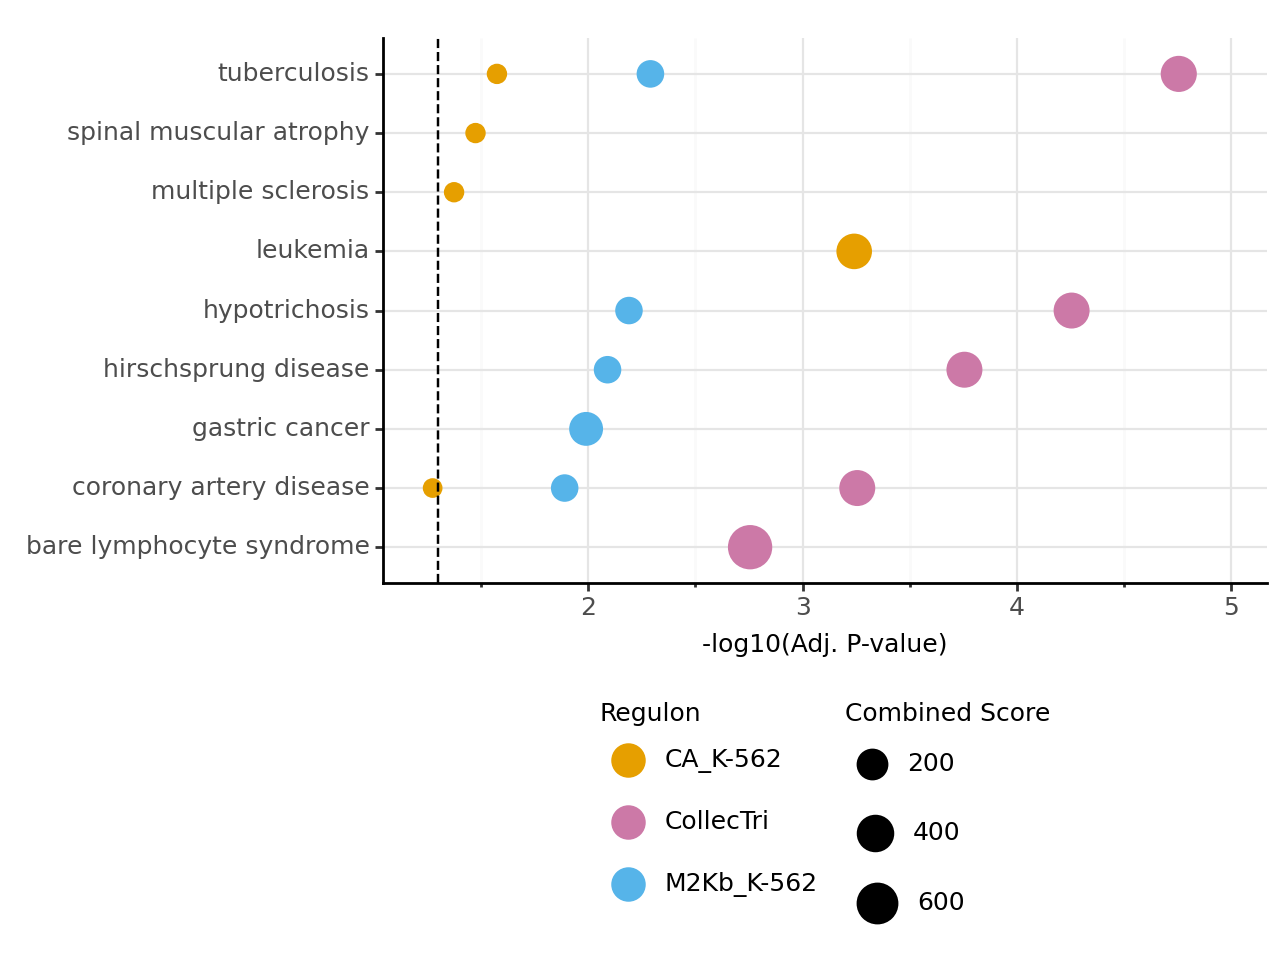

<Figure Size: (640 x 480)>

In [56]:
p = plot_enrich(aml_omim_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_omim_hsc_new_k562.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [57]:
aml_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(aml_disreg_enrich["Adjusted P-value"])
aml_disreg_enrich = aml_disreg_enrich.loc[aml_disreg_enrich["Adjusted P-value"] < 0.05]
aml_disreg_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,1.500000e+01,15.0,15.0,15.000000,15.000000,15.000000
mean,1.564497e-09,5.201306e-07,0.0,0.0,14.052601,351.512098,8.332747
std,2.643080e-09,7.090358e-07,0.0,0.0,4.505496,128.524337,2.944797
min,4.841542e-18,9.949369e-15,0.0,0.0,8.592960,204.624935,5.618045
25%,2.316425e-14,1.009445e-11,0.0,0.0,10.860959,275.684868,6.111828
50%,3.106398e-10,1.659613e-07,0.0,0.0,13.126494,298.273773,6.779993
75%,2.360278e-09,7.729861e-07,0.0,0.0,16.141118,436.946303,11.040639
max,9.615535e-09,2.409653e-06,0.0,0.0,23.218517,608.650334,14.002204


In [58]:
aml_disreg_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network,-log10(Adj. P-value)
0,DisGeNET,Malignant neoplasm of lung,17/2449,3.106398e-10,3.892316e-07,0,0,13.624543,298.273773,ATF2;HDAC1;CTCF;FOXM1;GATA2;NR3C1;ETS1;PML;RES...,M2Kb_K-562,6.409792
1,DisGeNET,Carcinogenesis,20/4065,8.894438e-10,5.572366e-07,0,0,13.126494,273.561702,ATF1;ATF2;HDAC1;PLAG1;CTCF;FOXM1;NR3C1;ETS1;PM...,M2Kb_K-562,6.253960
2,DisGeNET,Malignant neoplasm of ovary,15/2026,3.015175e-09,1.259338e-06,0,0,12.180507,238.976777,HDAC1;PLAG1;CTCF;FOXM1;GATA2;NR3C1;ETS1;PML;KA...,M2Kb_K-562,5.899858
3,DisGeNET,Carcinoma of lung,16/2476,4.534318e-09,1.420375e-06,0,0,11.391220,218.843451,ATF2;HDAC1;CTCF;FOXM1;GATA2;NR3C1;ETS1;PML;RES...,M2Kb_K-562,5.847597
4,DisGeNET,Ovarian Carcinoma,15/2203,9.615535e-09,2.409653e-06,0,0,11.084843,204.624935,HDAC1;PLAG1;CTCF;FOXM1;GATA2;NR3C1;ETS1;PML;KA...,M2Kb_K-562,5.618045
0,DisGeNET,"Leukemia, Myelocytic, Acute",15/1703,8.115910e-12,1.262024e-08,0,0,23.218517,592.935797,CREBBP;SPI1;LEF1;IKZF1;GATA2;NR3C1;ELK1;KLF1;E...,CollecTri,7.898932
1,DisGeNET,leukemia,15/1941,5.343432e-11,4.154518e-08,0,0,20.084557,475.051353,CREBBP;SPI1;LEF1;NFATC3;IKZF1;GATA2;NR3C1;KLF1...,CollecTri,7.381479
2,DisGeNET,"Lupus Erythematosus, Systemic",12/1113,3.201825e-10,1.659613e-07,0,0,20.574387,449.799919,CREBBP;ELF1;SPI1;CREB1;SP1;IRF1;IRF2;CREM;IKZF...,CollecTri,6.779993
3,DisGeNET,Central neuroblastoma,13/1655,1.991299e-09,7.729861e-07,0,0,16.129923,323.154596,CREBBP;CREM;GATA2;NR3C1;ELK1;CREB1;SP1;IRF1;NF...,CollecTri,6.111828
4,DisGeNET,Neuroblastoma,13/1698,2.729257e-09,7.729861e-07,0,0,15.681438,309.225975,CREBBP;CREM;GATA2;NR3C1;ELK1;CREB1;SP1;IRF1;NF...,CollecTri,6.111828


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_hsc_new_k562.svg


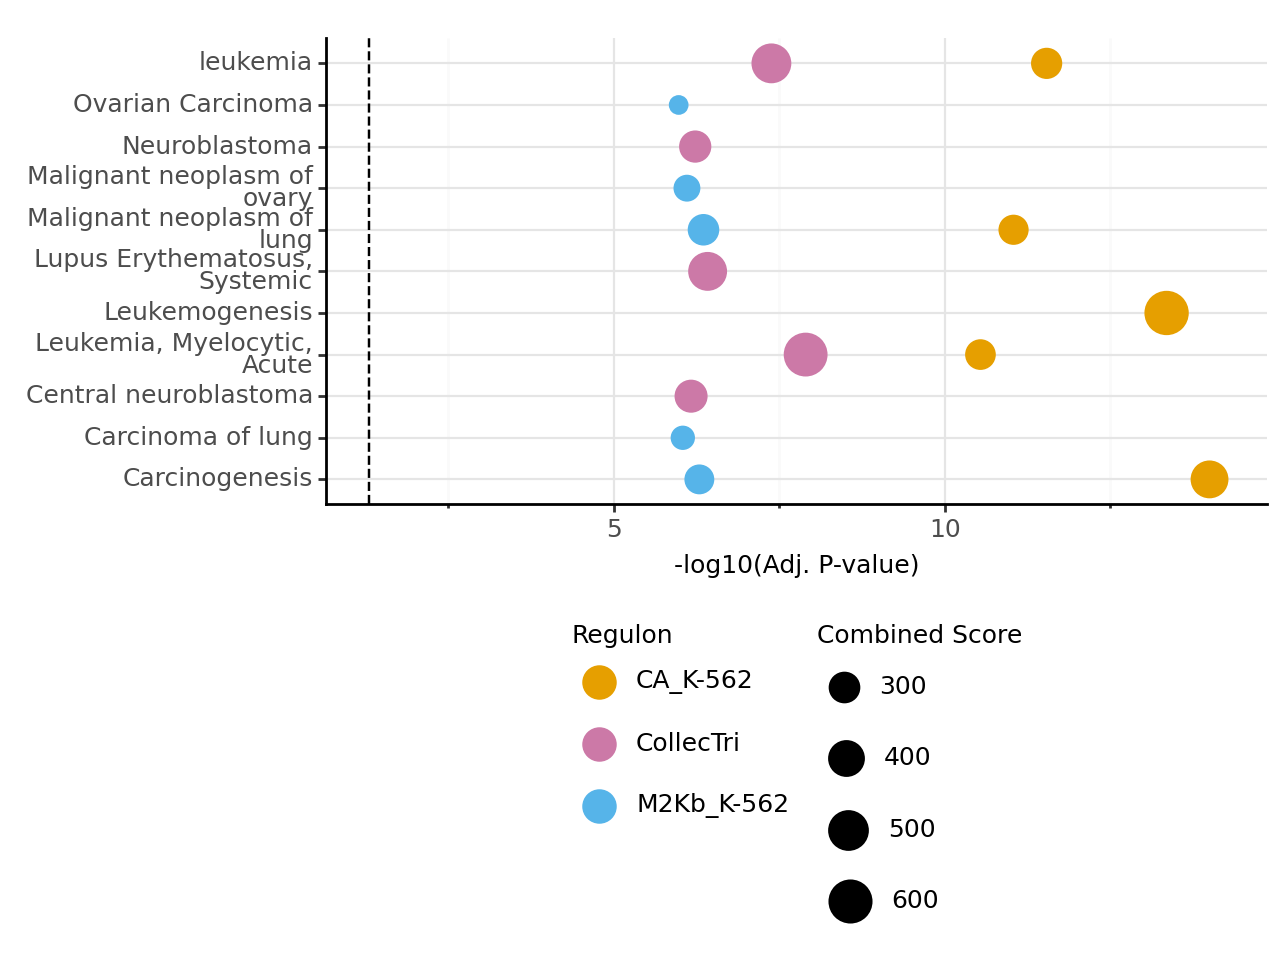

<Figure Size: (640 x 480)>

In [59]:
p = plot_enrich(aml_disreg_enrich, palette=okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_hsc_new_k562.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [60]:
aml_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(aml_cosmic_enrich["Adjusted P-value"])
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.006643,0.023176,75.045864,487.490024,1.976619
std,0.008349,0.020399,37.392483,363.588664,0.753111
min,0.000150,0.001200,35.971429,237.640063,1.376127
25%,0.000167,0.002172,42.655172,348.832860,1.376127
50%,0.001352,0.028387,84.066667,348.832860,1.546885
75%,0.015773,0.042060,84.066667,370.967476,2.663069
max,0.015773,0.042060,128.469388,1131.176858,2.920886


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_hsc_new_k562.svg


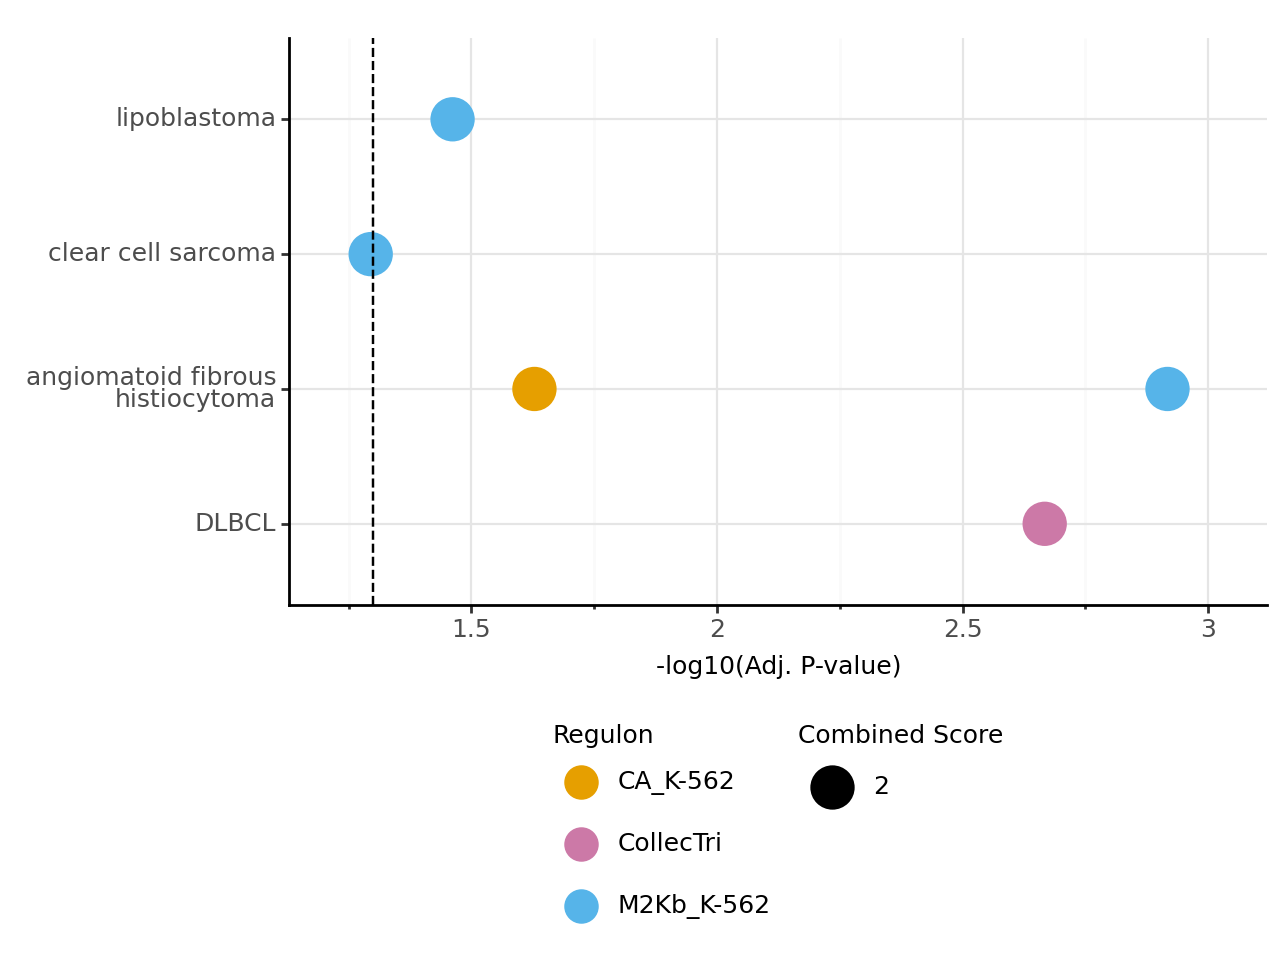

<Figure Size: (640 x 480)>

In [61]:
p = plot_enrich(aml_cosmic_enrich, okabe, size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_hsc_new_k562.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [62]:
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.006643,0.023176,75.045864,487.490024,1.976619
std,0.008349,0.020399,37.392483,363.588664,0.753111
min,0.000150,0.001200,35.971429,237.640063,1.376127
25%,0.000167,0.002172,42.655172,348.832860,1.376127
50%,0.001352,0.028387,84.066667,348.832860,1.546885
75%,0.015773,0.042060,84.066667,370.967476,2.663069
max,0.015773,0.042060,128.469388,1131.176858,2.920886


In [63]:
megaheat.describe()

,score,p_value
count,628.000000,628.000000
mean,0.620527,0.379280
std,1.273727,0.303456
min,-4.202702,0.000027
25%,-0.247654,0.089053
50%,0.622352,0.328456
75%,1.563516,0.641937
max,3.768019,0.997168


In [64]:
megaheat.to_csv("../data/3-tf_activity/aml_activity_estimates_hsc.tsv", sep="\t", index=False)

In [65]:
megaheat = megaheat[megaheat.p_value < 0.05].sort_values("score")
megaheat["TF"] = megaheat.index
megaheat["log_p"] = - np.log10(megaheat.p_value).round(1)
#megaheat["log_p"] = megaheat["log_p"].astype("str")

In [66]:
print(megaheat[megaheat.Network == "M2Kb_K-562"].sort_values("score").to_string())

            score   p_value     Network       TF  log_p
KAT2B   -2.213916  0.026905  M2Kb_K-562    KAT2B    1.6
ZNF77    2.009989  0.044517  M2Kb_K-562    ZNF77    1.4
ETS1     2.052511  0.040202  M2Kb_K-562     ETS1    1.4
CTCF     2.092229  0.036497  M2Kb_K-562     CTCF    1.4
HDAC1    2.104370  0.035424  M2Kb_K-562    HDAC1    1.5
PML      2.123158  0.033818  M2Kb_K-562      PML    1.5
FOXM1    2.130477  0.033209  M2Kb_K-562    FOXM1    1.5
KLF16    2.184381  0.029007  M2Kb_K-562    KLF16    1.5
NR3C1    2.188807  0.028683  M2Kb_K-562    NR3C1    1.5
GATA2    2.193378  0.028352  M2Kb_K-562    GATA2    1.5
IRF1     2.231071  0.025746  M2Kb_K-562     IRF1    1.6
BHLHE40  2.262822  0.023714  M2Kb_K-562  BHLHE40    1.6
NFATC3   2.263373  0.023680  M2Kb_K-562   NFATC3    1.6
SAP30    2.318604  0.020480  M2Kb_K-562    SAP30    1.7
ZBTB7A   2.339084  0.019393  M2Kb_K-562   ZBTB7A    1.7
ATF2     2.395787  0.016642  M2Kb_K-562     ATF2    1.8
MNT      2.408519  0.016074  M2Kb_K-562      MNT

In [67]:
print(megaheat[megaheat.Network == "CollecTri"].sort_values("score").to_string())

           score   p_value    Network      TF  log_p
SPI1   -4.202702  0.000027  CollecTri    SPI1    4.6
ELF1   -3.954784  0.000078  CollecTri    ELF1    4.1
SP1    -3.776416  0.000162  CollecTri     SP1    3.8
HEY1   -3.339543  0.000849  CollecTri    HEY1    3.1
RFX5   -2.920896  0.003515  CollecTri    RFX5    2.5
CREM   -2.515737  0.011927  CollecTri    CREM    1.9
CTNNB1 -2.487155  0.012928  CollecTri  CTNNB1    1.9
IRF1   -2.360886  0.018291  CollecTri    IRF1    1.7
CREBBP -2.335270  0.019591  CollecTri  CREBBP    1.7
IKZF1  -2.294379  0.021834  CollecTri   IKZF1    1.7
LEF1   -2.165952  0.030389  CollecTri    LEF1    1.5
NR3C1  -2.050395  0.040408  CollecTri   NR3C1    1.4
IRF2   -2.034342  0.042000  CollecTri    IRF2    1.4
GATA2   2.048440  0.040599  CollecTri   GATA2    1.4
ELK1    2.460927  0.013911  CollecTri    ELK1    1.9
CREB1   2.501038  0.012433  CollecTri   CREB1    1.9
NFATC3  2.573544  0.010111  CollecTri  NFATC3    2.0
E2F1    2.590117  0.009638  CollecTri    E2F1 

In [68]:
megaheat

,score,p_value,Network,TF,log_p
SPI1,-4.202702,0.000027,CollecTri,SPI1,4.6
ELF1,-3.954784,0.000078,CollecTri,ELF1,4.1
SP1,-3.776416,0.000162,CollecTri,SP1,3.8
HEY1,-3.339543,0.000849,CollecTri,HEY1,3.1
RFX5,-2.920896,0.003515,CollecTri,RFX5,2.5
...,...,...,...,...,...
YY1,3.353904,0.000806,CA_K-562,YY1,3.1
RREB1,3.356646,0.000798,CA_K-562,RREB1,3.1
FOXJ2,3.386021,0.000718,CA_K-562,FOXJ2,3.1
ZNF148,3.392079,0.000702,CA_K-562,ZNF148,3.2


/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


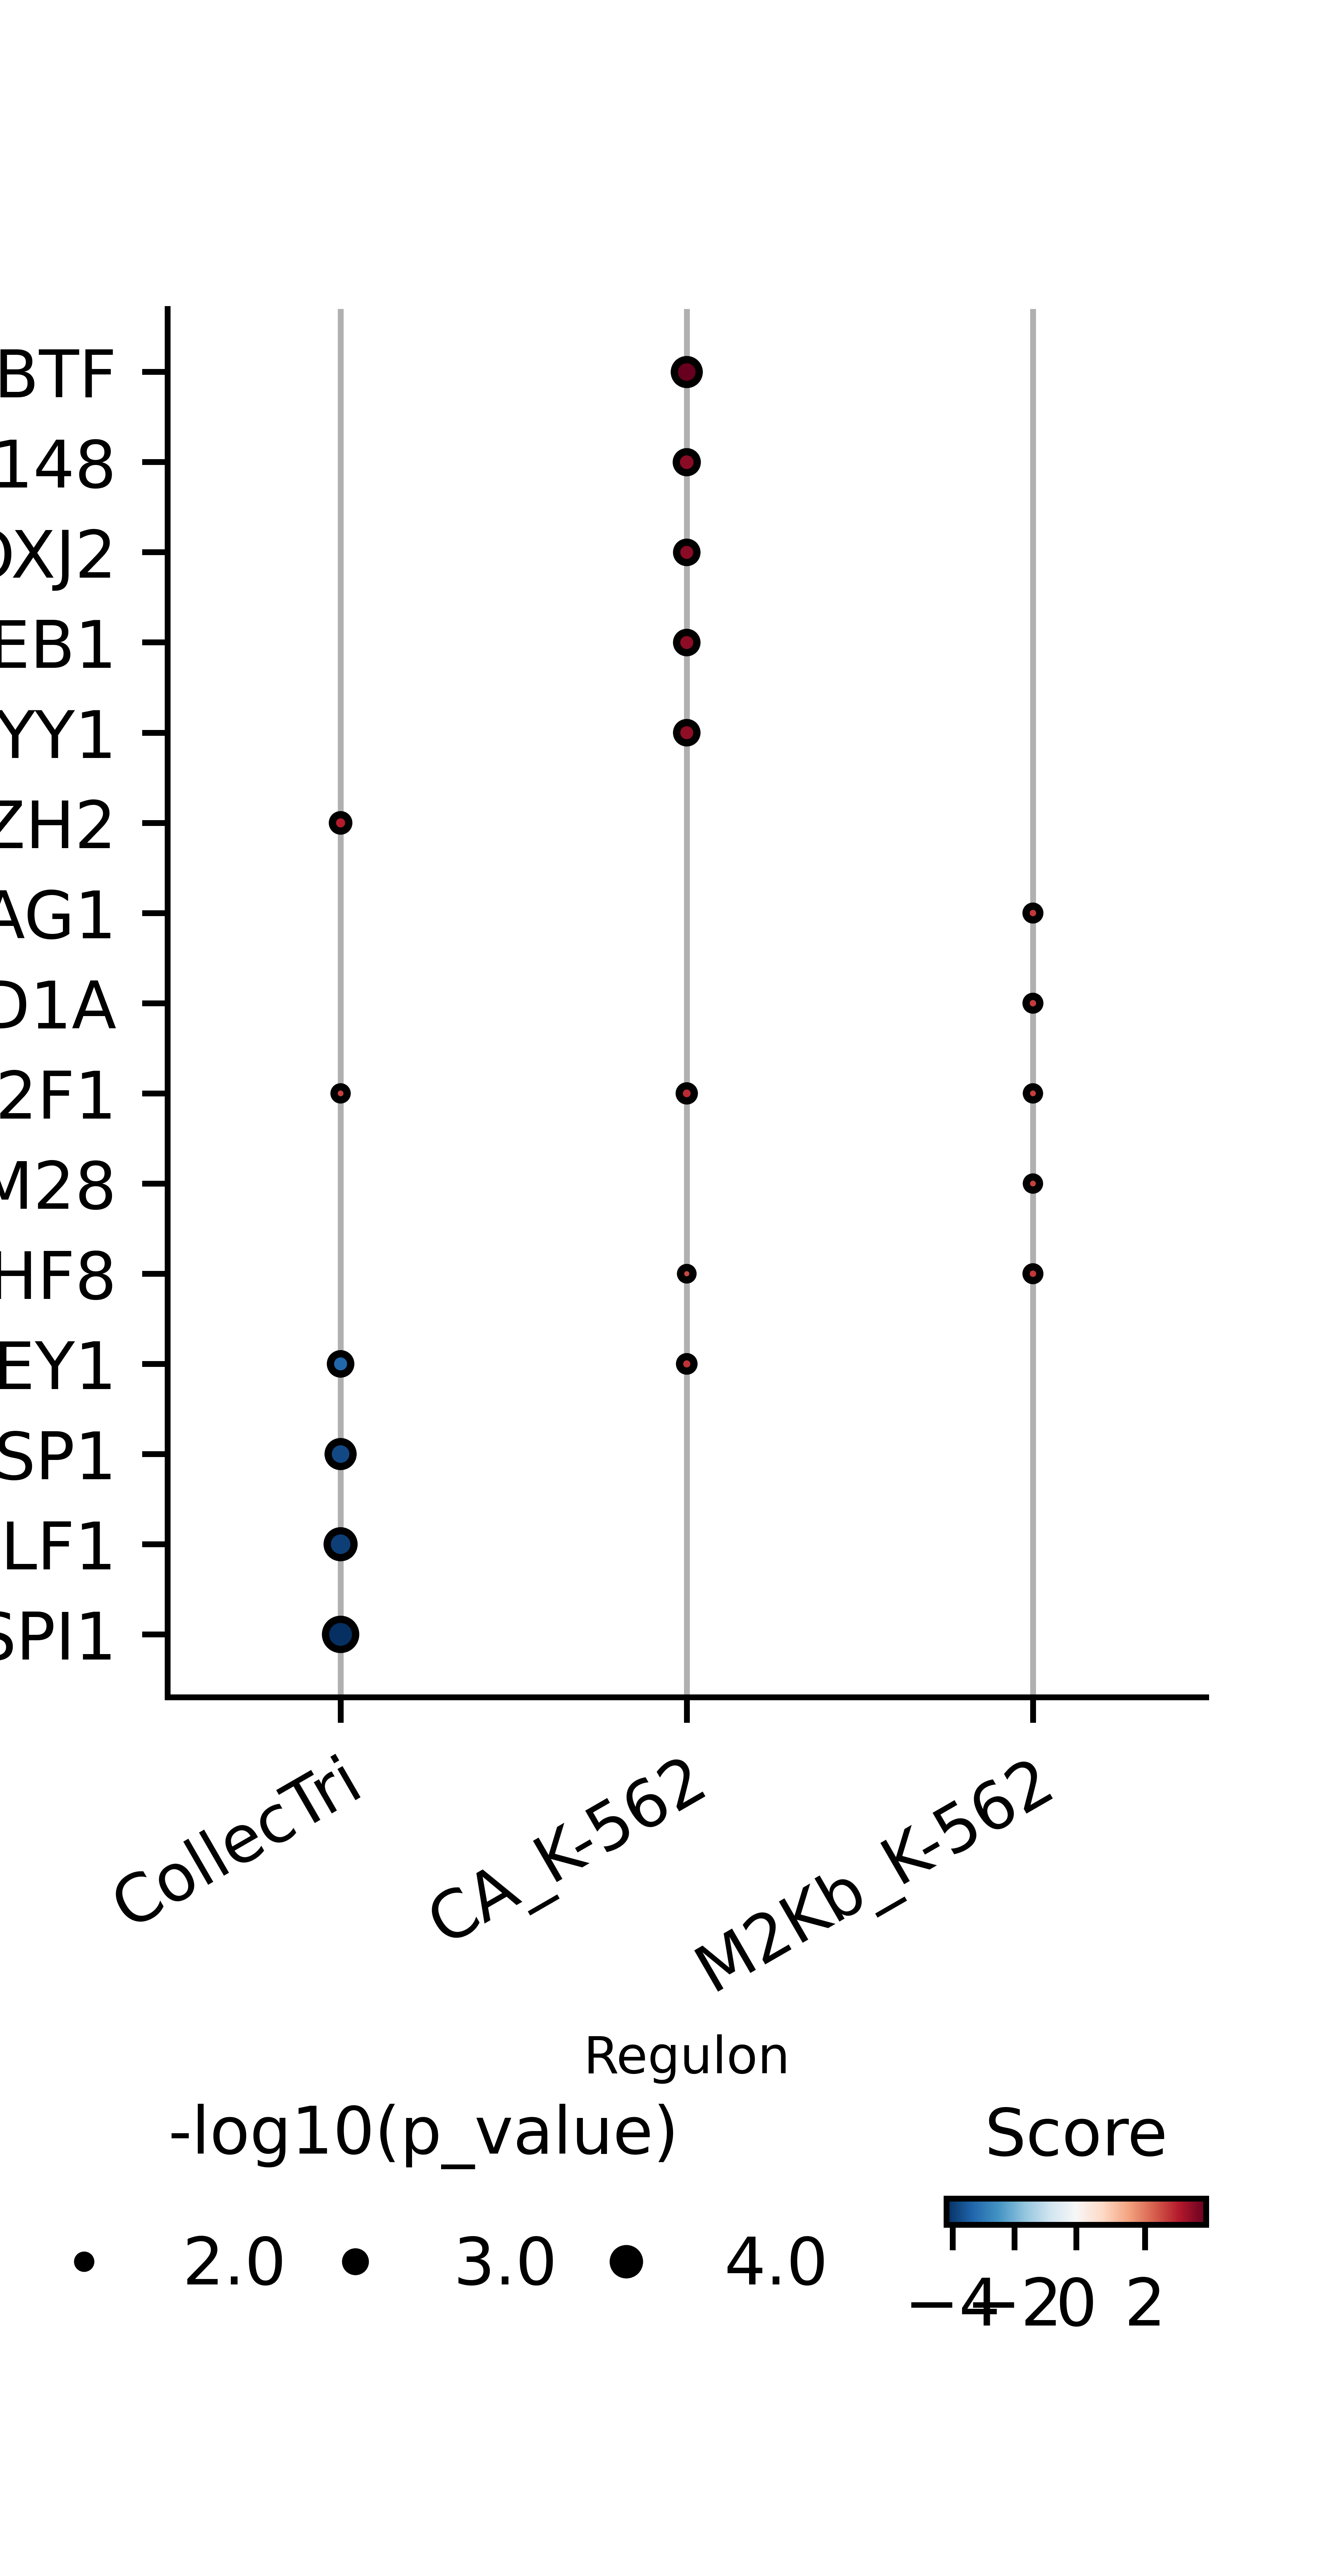

In [69]:
plt.close()
out = pd.DataFrame()
interesting_tf = []
for net in ["CollecTri", "M2Kb_K-562", "CA_K-562"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
plot_bubbles(out, scale=0.15)
plt.savefig("../plots/3-tf_activity/aml_activity_clustermap_hsc_k562.svg", dpi=720, format="svg")
plt.show()

In [70]:
len(megaheat[megaheat.Network == "CollecTri"].index.to_list())

22

In [71]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list()))

KAT2B, ZNF77, ETS1, CTCF, HDAC1, PML, FOXM1, KLF16, NR3C1, GATA2, IRF1, BHLHE40, NFATC3, SAP30, ZBTB7A, ATF2, MNT, SIN3A, REST, ATF1, CREB1, TRIM28, E2F1, CC2D1A, PLAG1, PHF8


In [72]:
print(", ".join(megaheat[megaheat.Network == "CollecTri"].index.to_list()))

SPI1, ELF1, SP1, HEY1, RFX5, CREM, CTNNB1, IRF1, CREBBP, IKZF1, LEF1, NR3C1, IRF2, GATA2, ELK1, CREB1, NFATC3, E2F1, KLF1, NFIC, NFE2, EZH2


In [73]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list()))

KAT2B, ZNF77, ETS1, CTCF, HDAC1, PML, FOXM1, KLF16, NR3C1, GATA2, IRF1, BHLHE40, NFATC3, SAP30, ZBTB7A, ATF2, MNT, SIN3A, REST, ATF1, CREB1, TRIM28, E2F1, CC2D1A, PLAG1, PHF8


In [74]:
print(", ".join(megaheat[megaheat.Network == "CollecTri"].index.to_list()))

SPI1, ELF1, SP1, HEY1, RFX5, CREM, CTNNB1, IRF1, CREBBP, IKZF1, LEF1, NR3C1, IRF2, GATA2, ELK1, CREB1, NFATC3, E2F1, KLF1, NFIC, NFE2, EZH2


In [75]:
enr = gp.enrich(megaheat[megaheat.Network == "CollecTri"].index.to_list(), "KEGG_2021_Human")
print(enr.results.head(5))
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_collectri_hsc.tsv", sep="\t", index=False)

          Gene_set                                             Term Overlap  \
0  KEGG_2021_Human  Kaposi sarcoma-associated herpesvirus infection   6/193   
1  KEGG_2021_Human                               Pathways in cancer   8/531   
2  KEGG_2021_Human                                  Prostate cancer    5/97   
3  KEGG_2021_Human          Human T-cell leukemia virus 1 infection   6/219   
4  KEGG_2021_Human                  Human cytomegalovirus infection   6/225   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  4.901047e-08          0.000002            0                     0   
1  5.396104e-08          0.000002            0                     0   
2  5.964251e-08          0.000002            0                     0   
3  1.037294e-07          0.000003            0                     0   
4  1.217140e-07          0.000003            0                     0   

   Odds Ratio  Combined Score                                       Genes  
0   39.687834   

In [76]:
enr = gp.enrich(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list(), "KEGG_2021_Human")
print(enr.results.head(5))
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)

          Gene_set                                     Term Overlap  \
0  KEGG_2021_Human  Human T-cell leukemia virus 1 infection   6/219   
1  KEGG_2021_Human                      Cellular senescence   4/156   
2  KEGG_2021_Human                              Hepatitis B   4/162   
3  KEGG_2021_Human                    Amphetamine addiction    3/69   
4  KEGG_2021_Human  Transcriptional misregulation in cancer   4/192   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  3.085767e-07          0.000027            0                     0   
1  4.657479e-05          0.001565            0                     0   
2  5.395666e-05          0.001565            0                     0   
3  9.652527e-05          0.001607            0                     0   
4  1.042939e-04          0.001607            0                     0   

   Odds Ratio  Combined Score                              Genes  
0   27.832394      417.243649  KAT2B;ATF2;CREB1;NFATC3;E2F1;ETS1  
1   23

### C6 healthy vs leukemic cells sc

In [168]:
adata = sc.read_h5ad("/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/data/case_study/seurat_main_cohort.h5ad")

/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.


In [169]:
adata.obs.value_counts("status")

status
 1             37268
-2147483648    34285
 0             25126
 2              5088
Name: count, dtype: int64

In [171]:
cts = ["HSCs & MPPs", "Erythro-myeloid progenitors", "Lymphomyeloid prog", "Early promyelocytes", "Late promyelocytes", "Plasmacytoid dendritic cell progenitors", "Early erythroid progenitor", "Late erythroid progenitor", "Megakaryocyte progenitors", "Eosinophil-basophil-mast cell progenitors"]


adata_sub = adata[(adata.obs.status == 1) & (adata.obs.ct.isin(cts)), :].copy()

adata_sub.obs.id = adata_sub.obs.id.astype("str")
adata_sub.obs["group"] = (adata_sub.obs.id == "6").astype(str)
adata_sub

AnnData object with n_obs × n_vars = 26896 × 39146
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_AB', 'nFeature_AB', 'percent.mt', 'patient', 'cohort', 'day', 'ct', 'ct_simple', 'pseudo_myel', 'projection_score', 'id', 'leukemia_prob', 'status', 'group'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_Projected', 'X_scanorama', 'X_umap'
    obsp: 'distances'

In [172]:
adata_sub.obs.ct.value_counts()

ct
Early promyelocytes                          13018
HSCs & MPPs                                   6767
Late promyelocytes                            3382
Lymphomyeloid prog                            2308
Erythro-myeloid progenitors                    637
Early erythroid progenitor                     397
Eosinophil-basophil-mast cell progenitors      184
Late erythroid progenitor                      111
Megakaryocyte progenitors                       61
Plasmacytoid dendritic cell progenitors         31
Name: count, dtype: int64

In [173]:
adata_sub.obs.value_counts(["patient", "group"])

patient  group
B.1      False    6132
A.11     False    3631
A.2      False    2520
A.6      False    2326
A.1      False    2299
B.4      False    2175
A.13     False    1922
A.5      False    1618
B.3      False    1214
A.3      False    1008
A.12     False     684
A.8      False     547
A.10     False     351
A.2      True      239
B.3      True       55
A.11     True       37
A.6      True       31
B.4      True       22
A.13     True       18
A.8      True       16
A.9      False      15
A.3      True       11
B.1      True        8
A.5      True        5
A.10     True        5
A.12     True        4
A.1      True        3
Name: count, dtype: int64

In [174]:
adata_sub.obs.value_counts("patient").shape

(14,)

In [175]:
de_genes_sc_temp = []
for patient in set(adata_sub.obs.patient.to_list()):
    try:
        adata_temp = adata_sub[adata_sub.obs.patient == patient].copy()
        sc.tl.rank_genes_groups(adata_temp, groupby="group", reference="False", use_raw=False, method="wilcoxon")
        de_genes_sc = sc.get.rank_genes_groups_df(adata_temp, group="True",  pval_cutoff=1e-2)
        de_genes_sc["patient"] = patient
        de_genes_sc_temp.append(de_genes_sc)
    except:
        continue

/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromn

In [176]:
de_genes_sc_temp = pd.concat(de_genes_sc_temp, axis=0)

In [177]:
de_genes_sc = de_genes_sc_temp.groupby("names").mean("logfoldchanges")
de_genes_sc = de_genes_sc.loc[de_genes_sc_temp.groupby("names").size() >= 3]# / de_genes_sc_temp.groupby("names").size()

In [181]:
de_genes_sc.sort_values("logfoldchanges")

,scores,logfoldchanges,pvals,pvals_adj,n_pat
names,,,,,
AZU1,-7.215080,-4.491127,7.638241e-07,1.582046e-04,0.0010
MPO,-5.966319,-4.323583,7.650133e-07,1.134323e-04,0.0010
RNASE2,-6.687984,-3.567366,1.356875e-06,2.629519e-04,0.0010
CTSG,-6.899257,-3.547728,3.787386e-07,8.282727e-05,0.0001
LGALS1,-7.502222,-2.950979,2.645016e-10,1.967827e-08,0.0001
...,...,...,...,...,...
KLF1,7.889207,4.311558,4.689533e-08,9.590054e-06,0.0010
AL157895.1,7.666239,4.737017,1.476447e-09,6.112422e-07,0.0001
ITGA2B,5.975086,4.951547,2.944438e-06,4.638247e-04,0.0010


In [182]:
de_genes = de_genes_sc
de_genes["leukemic"] = de_genes.logfoldchanges
de_genes

,scores,logfoldchanges,pvals,pvals_adj,n_pat,leukemic
names,,,,,,
ACSM3,8.905700,2.886529,2.312215e-06,2.391753e-04,0.0001,2.886529
ACTB,-1.662708,-0.474606,1.070067e-05,1.377695e-03,0.0010,-0.474606
AL157895.1,7.666239,4.737017,1.476447e-09,6.112422e-07,0.0001,4.737017
ALDH1A1,6.462049,3.270661,1.011877e-09,2.041714e-07,0.0010,3.270661
ANGPT1,-2.668520,1.163310,1.004545e-05,2.219088e-03,0.0001,1.163310
...,...,...,...,...,...,...
VSIR,-5.304823,-1.356066,3.449317e-05,1.013646e-03,0.0010,-1.356066
ZBTB16,5.407669,1.479284,3.870202e-05,4.098205e-03,0.0010,1.479284
ZBTB20,5.414096,2.235345,7.449789e-07,7.256202e-05,0.0010,2.235345


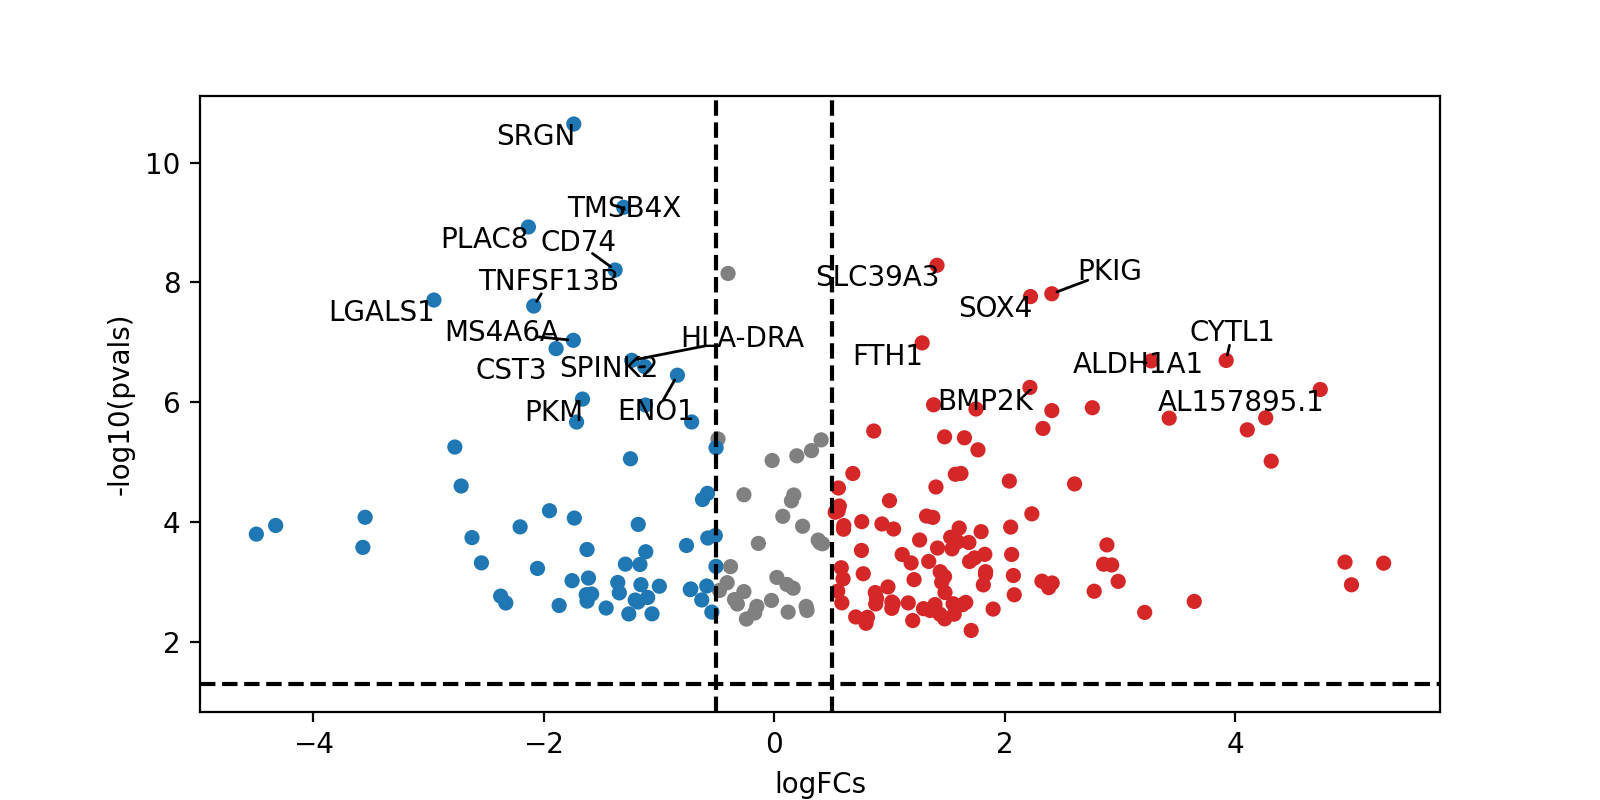

In [184]:
dc.plot_volcano_df(
    de_genes_sc,
    y='pvals_adj',
    x='logfoldchanges',
    top=20,
    figsize=(8, 4),
)

In [185]:
enr = gp.enrich(de_genes.index.to_list(), "DisGeNET", )
enr.results.loc[enr.results["Adjusted P-value"] < 0.05]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,"Liver Cirrhosis, Experimental",39/801,2.055342e-16,4.748258e-13,0,0,5.977199,215.901929,CFD;ITGA2B;ITGB2;SRI;VSIR;PLAC8;PYCARD;LGALS1;...
1,DisGeNET,leukemia,61/1941,2.424436e-16,4.748258e-13,0,0,4.123276,148.255532,IGHM;CD82;ITGA2B;ITGB2;MSI2;MPO;ACTB;TNFSF13B;...
2,DisGeNET,"Leukemia, Myelocytic, Acute",55/1703,3.665075e-15,4.785366e-12,0,0,4.120641,136.969808,CD82;ITGA2B;ITGB2;MSI2;MPO;ACTB;MYC;CASP3;ANXA...
3,DisGeNET,Neoplasm Metastasis,88/3920,5.593672e-15,5.477604e-12,0,0,3.216240,105.547799,IFITM3;ACSM3;CD82;ITGA2B;ITGB2;ENO1;MPO;ACTB;T...
4,DisGeNET,Multiple Myeloma,47/1312,1.408052e-14,1.103068e-11,0,0,4.442438,141.687043,RPL5;IGHM;CD82;GSTP1;ITGB2;SLC40A1;ICAM3;ENO1;...
...,...,...,...,...,...,...,...,...,...,...
924,DisGeNET,Chondrosarcoma,7/241,1.145393e-02,4.845037e-02,0,0,3.001271,13.413948,PRDX2;ANGPT1;MYC;IL1B;TMSB4X;CASP3;SOX4
925,DisGeNET,Metastatic Prostate Carcinoma,7/241,1.145393e-02,4.845037e-02,0,0,3.001271,13.413948,CD82;BIN1;MYC;IL1B;CASP3;VIM;GATA2
926,DisGeNET,Choriocarcinoma,8/300,1.146795e-02,4.845736e-02,0,0,2.754696,12.308528,LGALS1;PKM;MALAT1;HLA-A;B2M;CD34;GAPDH;S100A11
927,DisGeNET,Tumor Immunity,5/134,1.169970e-02,4.938334e-02,0,0,3.869870,17.213922,JUN;LGALS1;JUND;IL18;HLA-A


In [186]:
de_genes = pd.DataFrame(de_genes["leukemic"])

In [187]:
de_genes = de_genes.T

In [188]:
dc.check_corr(k562, mat=de_genes, source="tf", target="gene_symbol", weight=None).sort_values("corr")

,source1,source2,corr
2653,GTF2B,RBFOX2,-0.3606
6423,RBFOX2,SIRT6,-0.2651
7285,RBFOX2,ZMIZ1,-0.2490
7550,RBFOX2,ZHX1,-0.2443
8819,E2F3,RBFOX2,-0.2232
...,...,...,...
4,HCFC1,MBD2,0.7016
3,GFI1B,JUND,0.7048
2,CREM,JUND,0.7071
1,ETS1,RB1,0.7236


In [189]:
dc.check_corr(collectri, mat=de_genes, weight=None).sort_values("corr")

,source1,source2,corr
218,JUN,TAL1,-0.1546
236,EGR1,MYC,-0.1407
262,MYC,STAT1,-0.1296
263,CREB1,MYC,-0.1246
266,CREB1,GATA2,-0.1193
...,...,...,...
4,FOS,JUN,0.5749
3,EZH2,YY1,0.5765
2,GATA1,GATA2,0.5946
1,E2F1,TCF7L2,0.6540


In [190]:
aml_disreg_enrich = pd.DataFrame()
aml_omim_enrich = pd.DataFrame()
aml_cosmic_enrich = pd.DataFrame()
megaheat_sc = pd.DataFrame()

In [191]:
de_genes

names,ACSM3,ACTB,AL157895.1,ALDH1A1,ANGPT1,ANXA6,ARHGAP22,ARL6IP5,AZU1,B2M,...,TSC22D1,TSPO,TYROBP,UBA52,VIM,VSIR,ZBTB16,ZBTB20,ZEB2,ZMYND8
leukemic,2.886529,-0.474606,4.737017,3.270661,1.16331,-1.622311,1.662095,0.121376,-4.491127,0.14995,...,2.060243,-1.116275,-1.713571,-0.262323,-1.113525,-1.356066,1.479284,2.235345,-0.715318,1.650574


K562

In [192]:
tf_acts_k562, tf_pvals_k562= dc.run_ulm(de_genes, k562, source='tf', target='gene_symbol', weight="weight")

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [193]:
mask = tf_pvals_k562 < 0.05
active_tfs_k562 = tf_acts_k562.loc["leukemic", pd.DataFrame(tf_acts_k562 * mask).sum(axis=0) != 0].index.to_list()

In [194]:
active_tfs_k562

['ARID3A',
 'ARID3B',
 'ASH1L',
 'BCOR',
 'BHLHE40',
 'BRD4',
 'CC2D1A',
 'CREB1',
 'CREM',
 'CTCF',
 'CTCFL',
 'E2F1',
 'E2F6',
 'EGR1',
 'ETS1',
 'FOXM1',
 'GABPA',
 'GATA1',
 'GATA2',
 'GFI1B',
 'HDAC1',
 'KDM5B',
 'MBD2',
 'MTA2',
 'MTA3',
 'MYC',
 'NCOR1',
 'NONO',
 'NR2F2',
 'NR3C1',
 'NR4A1',
 'NRF1',
 'PBX2',
 'PLAG1',
 'RB1',
 'REST',
 'RLF',
 'SAP30',
 'SIN3A',
 'SKIL',
 'SMAD5',
 'SMARCA4',
 'SMARCE1',
 'SOX6',
 'STAT5A',
 'TAF1',
 'TAL1',
 'TBP',
 'TCF3',
 'TRIM24',
 'TRIM28',
 'UBTF',
 'YY1',
 'ZNF148',
 'ZNF24']

In [195]:
tf_acts_k562.index = ["score"]
tf_pvals_k562.index = ["p_value"]
out_k562 = pd.merge(left=tf_acts_k562.T, right=tf_pvals_k562.T, left_index=True, right_index=True)
out_k562.to_csv("../data/3-tf_activity/aml_k562_activity_m2kb_sc.tsv", sep="\t", index=False)

In [196]:
out_k562.sort_values("p_value")

,score,p_value
GATA2,3.638054,0.000350
REST,3.464761,0.000649
CREM,3.319309,0.001072
TAF1,3.151404,0.001875
TBP,3.118739,0.002084
...,...,...
CUX1,-0.030777,0.975478
NFIC,0.030365,0.975806
SMAD3,-0.019972,0.984086
USF1,-0.012385,0.990131


In [197]:
active_tfs_k562

['ARID3A',
 'ARID3B',
 'ASH1L',
 'BCOR',
 'BHLHE40',
 'BRD4',
 'CC2D1A',
 'CREB1',
 'CREM',
 'CTCF',
 'CTCFL',
 'E2F1',
 'E2F6',
 'EGR1',
 'ETS1',
 'FOXM1',
 'GABPA',
 'GATA1',
 'GATA2',
 'GFI1B',
 'HDAC1',
 'KDM5B',
 'MBD2',
 'MTA2',
 'MTA3',
 'MYC',
 'NCOR1',
 'NONO',
 'NR2F2',
 'NR3C1',
 'NR4A1',
 'NRF1',
 'PBX2',
 'PLAG1',
 'RB1',
 'REST',
 'RLF',
 'SAP30',
 'SIN3A',
 'SKIL',
 'SMAD5',
 'SMARCA4',
 'SMARCE1',
 'SOX6',
 'STAT5A',
 'TAF1',
 'TAL1',
 'TBP',
 'TCF3',
 'TRIM24',
 'TRIM28',
 'UBTF',
 'YY1',
 'ZNF148',
 'ZNF24']

In [198]:
enr = gp.enrich(active_tfs_k562, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [199]:
enr = gp.enrich(active_tfs_k562, "DisGeNET")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [200]:
try:
    enr = gp.enrich(gene_list=active_tfs_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [201]:
heat = pd.concat([tf_acts_k562.rename({"leukemic": "score"}), tf_pvals_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "M2Kb_K-562"
#heat["TFs"] = heat.index
megaheat_sc = pd.concat([megaheat_sc, heat], axis =0)
megaheat_sc

,score,p_value,Network
ARHGAP35,1.291768,0.197928,M2Kb_K-562
ARID1B,0.964519,0.335951,M2Kb_K-562
ARID3A,2.815407,0.005359,M2Kb_K-562
ARID3B,2.040412,0.042624,M2Kb_K-562
ARNT,0.768338,0.443193,M2Kb_K-562
...,...,...,...
ZNF395,1.075721,0.283348,M2Kb_K-562
ZNF436,1.805759,0.072460,M2Kb_K-562
ZNF444,-0.417347,0.676872,M2Kb_K-562
ZNF76,-0.156239,0.876002,M2Kb_K-562


CollecTri

In [202]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri, weight="weight")
#tf_pvals_ctri.loc["leukemic"] = fdrcorrection(tf_pvals_ctri.T["leukemic"])[1]

In [203]:
mask_ctri = tf_pvals_ctri < 0.05
active_tfs_ctri = tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].index.to_list()
tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].sort_values()

SP1     -3.450889
SPI1    -2.220521
MYC     -2.105513
ETS1     1.988901
GATA2    2.475935
Name: leukemic, dtype: float32

In [204]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/aml_k562_activity_collectri_sc.tsv", sep="\t", index=False)

In [205]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_collectri_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [206]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_collectri_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [207]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network
0,DisGeNET,"Acute Myeloid Leukemia, M1",3/116,0.000002,0.000533,0,0,263.920354,3.478888e+03,SPI1;MYC;GATA2,CollecTri
1,DisGeNET,Acute Myeloid Leukemia (AML-M2),3/121,0.000002,0.000533,0,0,252.673729,3.298472e+03,SPI1;MYC;GATA2,CollecTri
2,DisGeNET,Friend leukemia,2/10,0.000002,0.000533,0,0,1665.583333,2.166160e+04,SPI1;ETS1,CollecTri
3,DisGeNET,Multiple malignancy,3/176,0.000007,0.001175,0,0,171.867052,2.049770e+03,SP1;MYC;ETS1,CollecTri
4,DisGeNET,leukemia,5/1941,0.000009,0.001219,0,0,90295.000000,1.053505e+06,SPI1;SP1;MYC;GATA2;ETS1,CollecTri
...,...,...,...,...,...,...,...,...,...,...,...
706,DisGeNET,Epilepsy,1/1177,0.261618,0.263098,0,0,4.000638,5.364330e+00,SP1,CollecTri
707,DisGeNET,Hypertensive disease,1/1310,0.287341,0.288559,0,0,3.568755,4.450539e+00,SP1,CollecTri
708,DisGeNET,Renal Cell Carcinoma,1/1348,0.294557,0.295388,0,0,3.461024,4.230345e+00,MYC,CollecTri
709,DisGeNET,Schizophrenia,1/1923,0.396803,0.397362,0,0,2.350806,2.172886e+00,SP1,CollecTri


In [208]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_collectri_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [209]:
heat = pd.concat([tf_acts_ctri.rename({"leukemic": "score"}), tf_pvals_ctri.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat_sc = pd.concat([megaheat_sc, heat], axis =0)
megaheat_sc

,score,p_value,Network
ARHGAP35,1.291768,0.197928,M2Kb_K-562
ARID1B,0.964519,0.335951,M2Kb_K-562
ARID3A,2.815407,0.005359,M2Kb_K-562
ARID3B,2.040412,0.042624,M2Kb_K-562
ARNT,0.768338,0.443193,M2Kb_K-562
...,...,...,...
TAL1,-0.755975,0.450554,CollecTri
TBP,-0.585990,0.558543,CollecTri
TCF7L2,-0.248081,0.804327,CollecTri
TP53,-1.406093,0.161248,CollecTri


chip_atlas_k562

In [210]:
tf_acts_chip_atlas_k562, tf_pvals_chip_atlas_k562 = dc.run_ulm(de_genes, chip_atlas_k562.drop_duplicates(), source='tf', target='Target_genes', weight="weight")

In [211]:
tf_pvals_chip_atlas_k562

,ADNP,ARHGAP35,ARID1B,ARID3A,ARNT,ASH1L,ATF1,ATF2,ATF3,ATF4,...,ZNF148,ZNF175,ZNF184,ZNF239,ZNF24,ZNF263,ZNF281,ZNF316,ZNF384,ZNF395
leukemic,0.42914,0.834389,0.200931,0.066438,0.546679,0.15231,0.134027,0.03834,0.375791,0.250783,...,0.00239,0.336879,0.090614,0.142428,0.911977,0.319303,0.026428,0.104994,0.077718,0.035686


In [212]:
mask_chip_atlas_k562 = tf_pvals_chip_atlas_k562 < 0.05

active_tfs_chip_atlas_k562 = tf_acts_chip_atlas_k562.loc["leukemic", pd.DataFrame(tf_acts_chip_atlas_k562 * mask_chip_atlas_k562).sum(axis=0) != 0].index.to_list()

In [213]:
tf_acts_chip_atlas_k562.index = ["score"]
tf_pvals_chip_atlas_k562.index = ["p_value"]
out_chip_atlas = pd.merge(left=tf_acts_chip_atlas_k562.T, right=tf_pvals_chip_atlas_k562.T, left_index=True, right_index=True)
out_chip_atlas.to_csv("../data/3-tf_activity/aml_k562_activity_ca_k562_sc.tsv", sep="\t", index=False)

In [214]:
active_tfs_chip_atlas_k562

['ATF2',
 'BCOR',
 'BHLHE40',
 'BRD4',
 'CBFA2T3',
 'CREB1',
 'CREB3',
 'CREM',
 'CTBP1',
 'CUX1',
 'E2F4',
 'E2F6',
 'EGR1',
 'FOXK2',
 'GABPA',
 'GATA1',
 'GATA2',
 'GMEB1',
 'HCFC1',
 'HDAC1',
 'HEY1',
 'IKZF1',
 'JUND',
 'KDM5B',
 'KLF16',
 'LDB1',
 'MAX',
 'MAZ',
 'MBD2',
 'MGA',
 'MIER1',
 'MNT',
 'MYC',
 'NCOR1',
 'NEUROD1',
 'NR2F2',
 'NR2F6',
 'PBX2',
 'PHF8',
 'PKNOX1',
 'PLAG1',
 'PRDM10',
 'RBFOX2',
 'RCOR1',
 'REST',
 'SIN3A',
 'SMAD5',
 'TAF1',
 'TBP',
 'TCF12',
 'TCF3',
 'TFDP1',
 'TRIM24',
 'TRIM28',
 'UBTF',
 'USF1',
 'YY1',
 'ZBTB7A',
 'ZFX',
 'ZNF148',
 'ZNF281',
 'ZNF395']

In [215]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "OMIM_Expanded")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_ca_k562_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [216]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "DisGeNET")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_ca_k562_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)


In [217]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_ca_k562_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results[enr.results["Adjusted P-value"] < 0.05].sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [218]:
heat = pd.concat([tf_acts_chip_atlas_k562.rename({"leukemic": "score"}), tf_pvals_chip_atlas_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "CA_K-562"
#heat["TFs"] = heat.index
megaheat_sc = pd.concat([megaheat_sc, heat], axis =0)
megaheat_sc

,score,p_value,Network
ARHGAP35,1.291768,0.197928,M2Kb_K-562
ARID1B,0.964519,0.335951,M2Kb_K-562
ARID3A,2.815407,0.005359,M2Kb_K-562
ARID3B,2.040412,0.042624,M2Kb_K-562
ARNT,0.768338,0.443193,M2Kb_K-562
...,...,...,...
ZNF263,-0.998377,0.319303,CA_K-562
ZNF281,2.236436,0.026428,CA_K-562
ZNF316,1.628498,0.104994,CA_K-562
ZNF384,1.773200,0.077718,CA_K-562


Plotting results

In [219]:
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}
okabe = [pal[1], pal[7], pal[2]]

In [220]:
aml_omim_enrich["-log10(Adj. P-value)"] = - np.log10(aml_omim_enrich["Adjusted P-value"])
aml_omim_enrich = aml_omim_enrich.loc[aml_omim_enrich["Adjusted P-value"] < 0.05]
aml_omim_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,11.000000,11.000000,11.0,11.0,11.000000,11.000000,11.000000
mean,0.011872,0.019164,0.0,0.0,15.155210,78.426069,1.920423
std,0.011485,0.015004,0.0,0.0,12.116631,51.145544,0.487747
min,0.000140,0.003731,0.0,0.0,8.816870,32.910210,1.474590
25%,0.002499,0.003731,0.0,0.0,8.922282,33.495652,1.474590
50%,0.002499,0.024508,0.0,0.0,12.018160,72.013538,1.610684
75%,0.023675,0.033528,0.0,0.0,13.755052,87.807452,2.428203
max,0.024508,0.033528,0.0,0.0,50.757653,188.246816,2.428203


In [221]:
aml_omim_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network,-log10(Adj. P-value)
0,OMIM_Expanded,leukemia,3/77,0.001246,0.033528,0,0,15.491944,103.601365,TAL1;TCF3;GATA1,M2Kb_K-562,1.474590
96,OMIM_Expanded,spinal muscular atrophy,2/86,0.023420,0.033528,0,0,8.922282,33.495652,CREB1;PLAG1,M2Kb_K-562,1.474590
97,OMIM_Expanded,tuberculosis,2/86,0.023420,0.033528,0,0,8.922282,33.495652,CREB1;PLAG1,M2Kb_K-562,1.474590
98,OMIM_Expanded,coronary artery disease,2/87,0.023930,0.033528,0,0,8.816870,32.910210,CREB1;PLAG1,M2Kb_K-562,1.474590
99,OMIM_Expanded,gastric cancer,2/87,0.023930,0.033528,0,0,8.816870,32.910210,CREB1;PLAG1,M2Kb_K-562,1.474590
0,OMIM_Expanded,lymphoma,1/99,0.024508,0.024508,0,0,50.757653,188.246816,MYC,CollecTri,1.610684
0,OMIM_Expanded,thalassemia,4/85,0.000140,0.003731,0,0,16.906769,149.972706,CREB1;PLAG1;CTBP1;GATA1,CA_K-562,2.428203
103,OMIM_Expanded,macular dystrophy,3/87,0.002499,0.003731,0,0,12.018160,72.013538,CREB1;PLAG1;CTBP1,CA_K-562,2.428203
102,OMIM_Expanded,hypotrichosis,3/87,0.002499,0.003731,0,0,12.018160,72.013538,CREB1;PLAG1;CTBP1,CA_K-562,2.428203
101,OMIM_Expanded,hirschsprung disease,3/87,0.002499,0.003731,0,0,12.018160,72.013538,CREB1;PLAG1;CTBP1,CA_K-562,2.428203


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_omim_hsc_new_k562_sc.svg


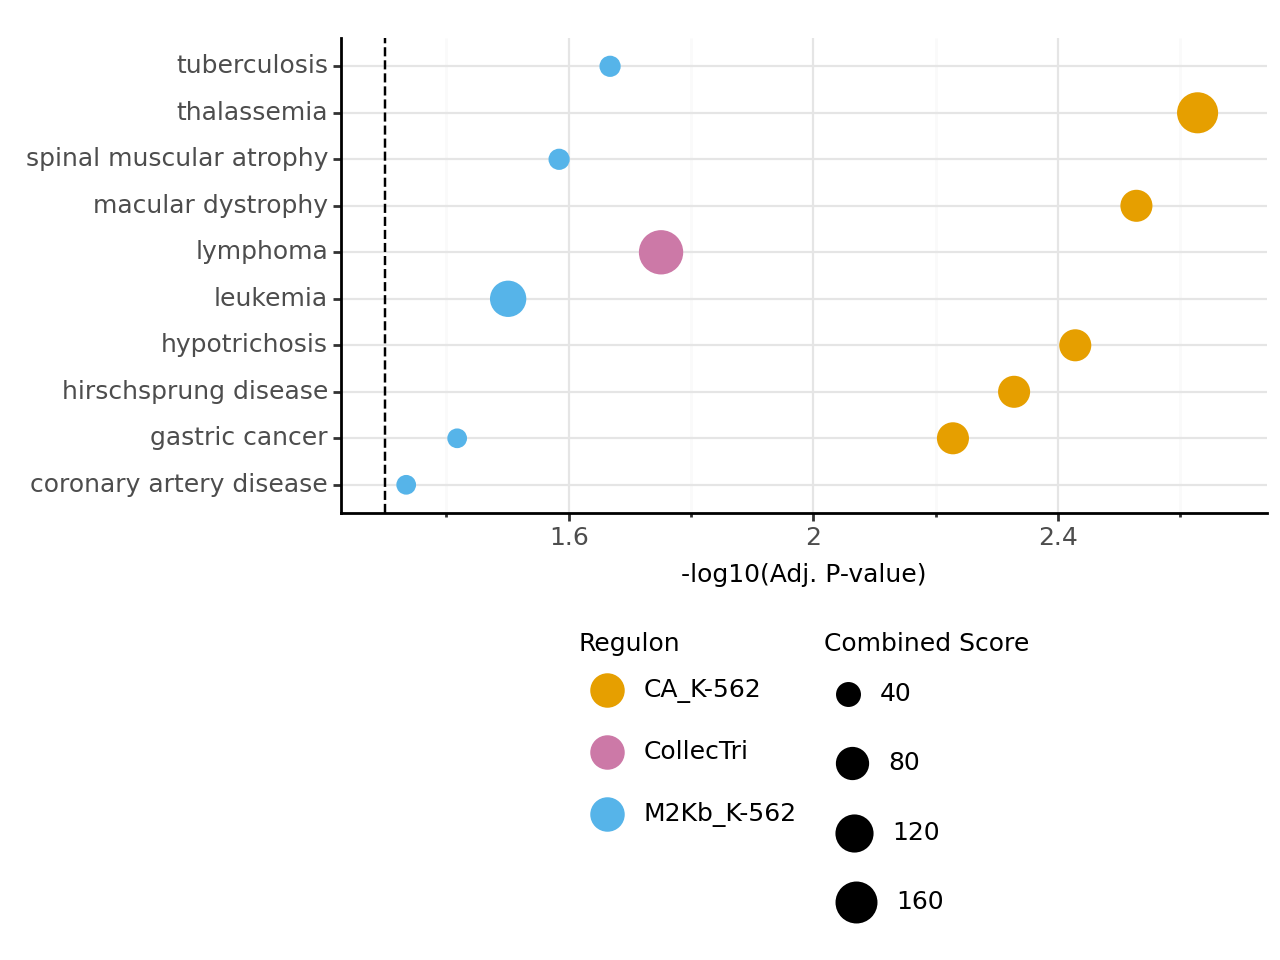

<Figure Size: (640 x 480)>

In [222]:
p = plot_enrich(aml_omim_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_omim_hsc_new_k562_sc.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [223]:
aml_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(aml_disreg_enrich["Adjusted P-value"])
aml_disreg_enrich = aml_disreg_enrich.loc[aml_disreg_enrich["Adjusted P-value"] < 0.05]
aml_disreg_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,1.500000e+01,15.0,15.0,15.000000,1.500000e+01,15.000000
mean,1.430396e-06,2.661588e-04,0.0,0.0,6183.215784,7.247608e+04,7.970320
std,2.668036e-06,4.355181e-04,0.0,0.0,23272.674148,2.714483e+05,3.771544
min,1.267243e-16,2.691625e-13,0.0,0.0,5.938822,1.458676e+02,2.914173
25%,8.656650e-15,3.579275e-12,0.0,0.0,7.346725,2.140945e+02,3.273430
50%,2.260642e-12,1.193362e-09,0.0,0.0,10.089691,3.540172e+02,8.923228
75%,2.012961e-06,5.328071e-04,0.0,0.0,212.270390,2.674121e+03,11.446205
max,8.568947e-06,1.218504e-03,0.0,0.0,90295.000000,1.053505e+06,12.569985


In [224]:
aml_disreg_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network,-log10(Adj. P-value)
0,DisGeNET,Leukemogenesis,21/730,1.267243e-16,2.691625e-13,0,0,16.757488,6.133998e+02,RB1;STAT5A;KDM5B;EGR1;HDAC1;MBD2;CTCF;FOXM1;GA...,M2Kb_K-562,12.569985
1,DisGeNET,Malignant neoplasm of lung,32/2449,5.779605e-16,6.137941e-13,0,0,10.089691,3.540172e+02,RB1;KDM5B;HDAC1;CTCF;FOXM1;NR3C1;GATA2;ETS1;YY...,M2Kb_K-562,12.211977
2,DisGeNET,Primary malignant neoplasm of lung,30/2268,6.431299e-15,3.579275e-12,0,0,9.494370,3.102532e+02,RB1;KDM5B;HDAC1;CTCF;FOXM1;NR3C1;GATA2;ETS1;YY...,M2Kb_K-562,11.446205
3,DisGeNET,Carcinoma of lung,31/2476,7.651354e-15,3.579275e-12,0,0,9.245058,3.005004e+02,RB1;KDM5B;HDAC1;CTCF;FOXM1;NR3C1;GATA2;ETS1;YY...,M2Kb_K-562,11.446205
4,DisGeNET,Precursor T-Cell Lymphoblastic Leukemia-Lymphoma,16/408,9.661946e-15,3.579275e-12,0,0,20.463632,6.603733e+02,STAT5A;MBD2;PBX2;CTCF;FOXM1;NR3C1;ETS1;GATA1;C...,M2Kb_K-562,11.446205
0,DisGeNET,"Acute Myeloid Leukemia, M1",3/116,1.884999e-06,5.328071e-04,0,0,263.920354,3.478888e+03,SPI1;MYC;GATA2,CollecTri,3.273430
1,DisGeNET,Acute Myeloid Leukemia (AML-M2),3/121,2.140924e-06,5.328071e-04,0,0,252.673729,3.298472e+03,SPI1;MYC;GATA2,CollecTri,3.273430
2,DisGeNET,Friend leukemia,2/10,2.248131e-06,5.328071e-04,0,0,1665.583333,2.166160e+04,SPI1;ETS1,CollecTri,3.273430
3,DisGeNET,Multiple malignancy,3/176,6.612907e-06,1.175444e-03,0,0,171.867052,2.049770e+03,SP1;MYC;ETS1,CollecTri,2.929798
4,DisGeNET,leukemia,5/1941,8.568947e-06,1.218504e-03,0,0,90295.000000,1.053505e+06,SPI1;SP1;MYC;GATA2;ETS1,CollecTri,2.914173


In [225]:
aml_disreg_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,1.500000e+01,15.0,15.0,15.000000,1.500000e+01,15.000000
mean,1.430396e-06,2.661588e-04,0.0,0.0,6183.215784,7.247608e+04,7.970320
std,2.668036e-06,4.355181e-04,0.0,0.0,23272.674148,2.714483e+05,3.771544
min,1.267243e-16,2.691625e-13,0.0,0.0,5.938822,1.458676e+02,2.914173
25%,8.656650e-15,3.579275e-12,0.0,0.0,7.346725,2.140945e+02,3.273430
50%,2.260642e-12,1.193362e-09,0.0,0.0,10.089691,3.540172e+02,8.923228
75%,2.012961e-06,5.328071e-04,0.0,0.0,212.270390,2.674121e+03,11.446205
max,8.568947e-06,1.218504e-03,0.0,0.0,90295.000000,1.053505e+06,12.569985


In [226]:
aml_disreg_enrich.loc[(aml_disreg_enrich.Network == "CollecTri"), "Combined Score"] = aml_disreg_enrich.loc[(aml_disreg_enrich.Network == "CollecTri"), "Combined Score"]/100 

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_hsc_new_k562_sc.svg


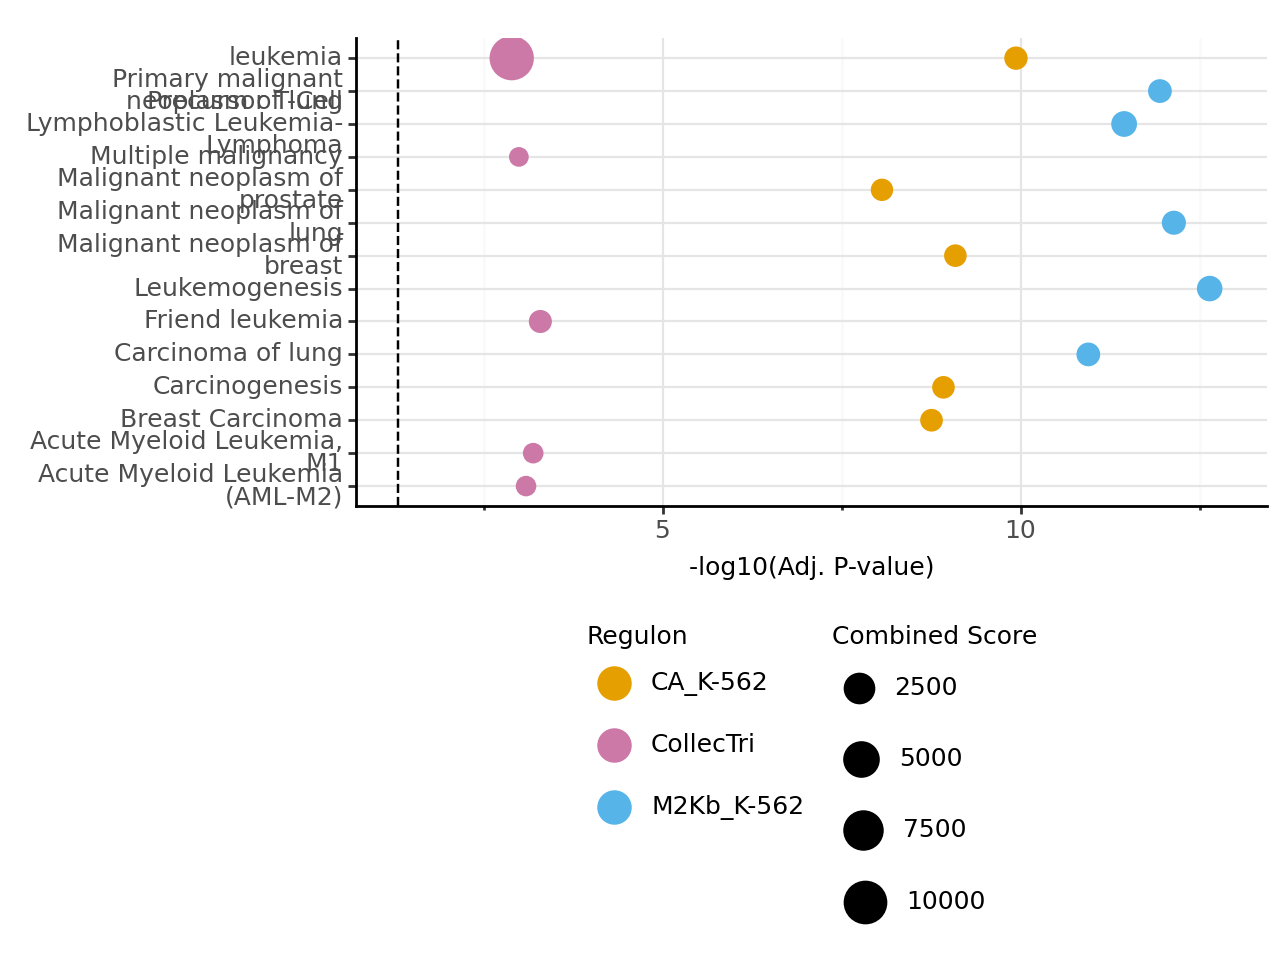

<Figure Size: (640 x 480)>

In [227]:
p = plot_enrich(aml_disreg_enrich, palette=okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_hsc_new_k562_sc.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [228]:
aml_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(aml_cosmic_enrich["Adjusted P-value"])
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.004019,0.010314,380.565286,2102.591649,2.025876
std,0.003543,0.005589,358.425857,2065.576789,0.220724
min,0.000982,0.006329,42.823129,296.568132,1.777223
25%,0.002074,0.007120,192.547928,976.490195,1.939485
50%,0.003165,0.007911,342.272727,1656.412257,2.101747
75%,0.005538,0.012307,549.436364,3005.603408,2.150202
max,0.007911,0.016702,756.600000,4354.794559,2.198657


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_hsc_new_k562_sc.svg


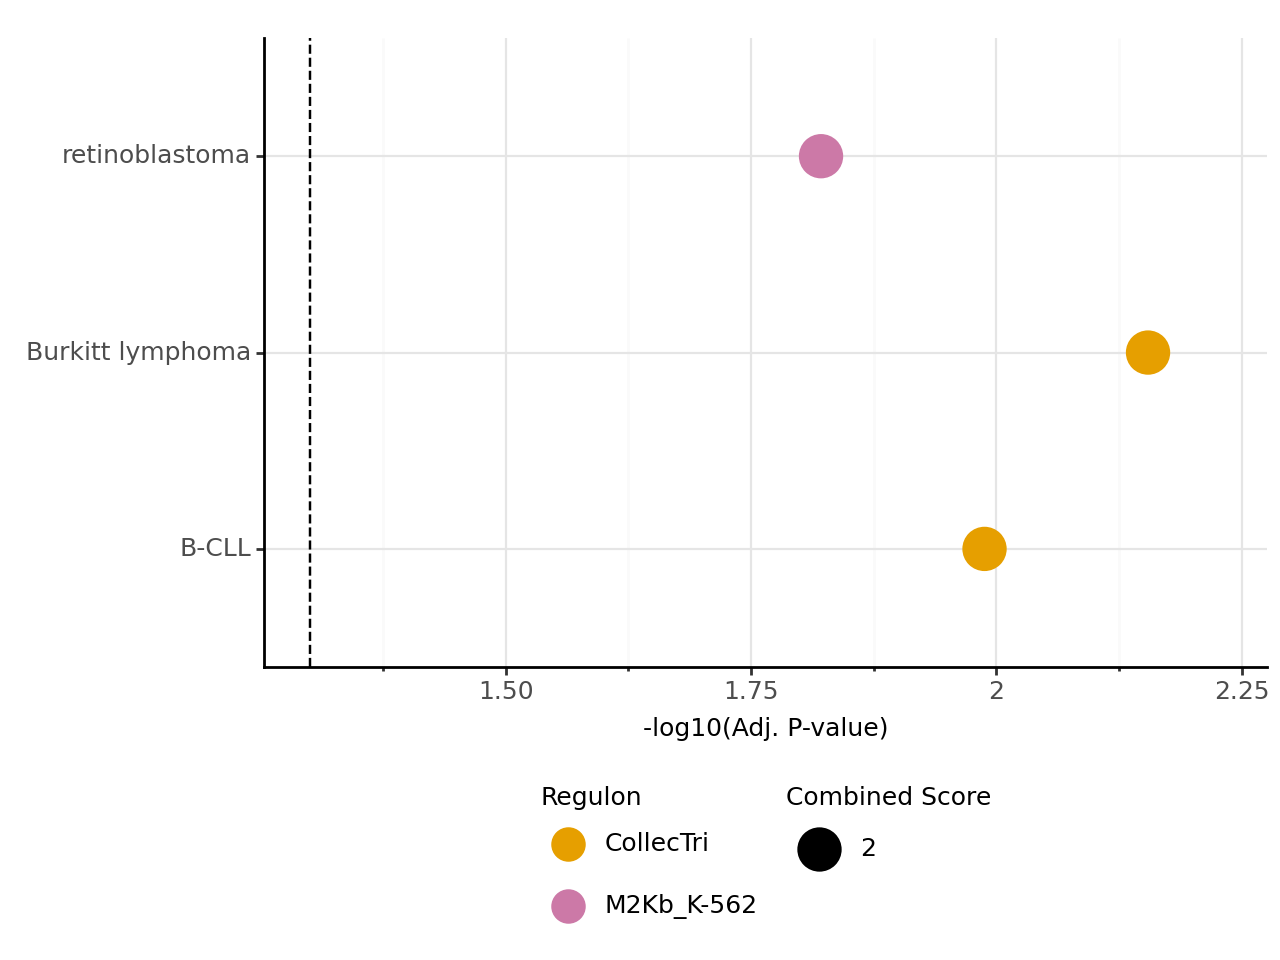

<Figure Size: (640 x 480)>

In [229]:
p = plot_enrich(aml_cosmic_enrich, okabe, size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_hsc_new_k562_sc.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [230]:
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.004019,0.010314,380.565286,2102.591649,2.025876
std,0.003543,0.005589,358.425857,2065.576789,0.220724
min,0.000982,0.006329,42.823129,296.568132,1.777223
25%,0.002074,0.007120,192.547928,976.490195,1.939485
50%,0.003165,0.007911,342.272727,1656.412257,2.101747
75%,0.005538,0.012307,549.436364,3005.603408,2.150202
max,0.007911,0.016702,756.600000,4354.794559,2.198657


In [231]:
megaheat_sc.describe()

,score,p_value
count,457.000000,457.000000
mean,1.272551,0.289945
std,1.051339,0.294048
min,-3.450889,0.000023
25%,0.676789,0.047658
50%,1.330932,0.171268
75%,1.986954,0.460000
max,4.340262,0.999231


In [232]:
megaheat_sc.to_csv("../data/3-tf_activity/aml_activity_estimates_hsc.tsv", sep="\t", index=False)

In [233]:
megaheat_sc = megaheat_sc[megaheat_sc.p_value < 0.05].sort_values("score")
megaheat_sc["TF"] = megaheat_sc.index
megaheat_sc["log_p"] = - np.log10(megaheat_sc.p_value).round(1)
#megaheat_sc["log_p"] = megaheat_sc["log_p"].astype("str")

In [234]:
print(megaheat_sc[megaheat_sc.Network == "M2Kb_K-562"].sort_values("score").to_string())

            score   p_value     Network       TF  log_p
YY1      1.975307  0.049609  M2Kb_K-562      YY1    1.3
PLAG1    1.975471  0.049590  M2Kb_K-562    PLAG1    1.3
RLF      1.978234  0.049275  M2Kb_K-562      RLF    1.3
TRIM24   1.991648  0.047770  M2Kb_K-562   TRIM24    1.3
ETS1     1.992661  0.047658  M2Kb_K-562     ETS1    1.3
SKIL     2.003568  0.046466  M2Kb_K-562     SKIL    1.3
ARID3B   2.040412  0.042624  M2Kb_K-562   ARID3B    1.4
CC2D1A   2.045091  0.042156  M2Kb_K-562   CC2D1A    1.4
BHLHE40  2.051509  0.041521  M2Kb_K-562  BHLHE40    1.4
NONO     2.066407  0.040078  M2Kb_K-562     NONO    1.4
NR2F2    2.087807  0.038082  M2Kb_K-562    NR2F2    1.4
BCOR     2.089868  0.037894  M2Kb_K-562     BCOR    1.4
EGR1     2.092489  0.037656  M2Kb_K-562     EGR1    1.4
CREB1    2.107149  0.036351  M2Kb_K-562    CREB1    1.4
GFI1B    2.127507  0.034603  M2Kb_K-562    GFI1B    1.5
SOX6     2.133268  0.034121  M2Kb_K-562     SOX6    1.5
BRD4     2.134589  0.034012  M2Kb_K-562     BRD4

In [235]:
print(megaheat_sc[megaheat_sc.Network == "CollecTri"].sort_values("score").to_string())

          score   p_value    Network     TF  log_p
SP1   -3.450889  0.000682  CollecTri    SP1    3.2
SPI1  -2.220521  0.027506  CollecTri   SPI1    1.6
MYC   -2.105513  0.036495  CollecTri    MYC    1.4
ETS1   1.988901  0.048075  CollecTri   ETS1    1.3
GATA2  2.475935  0.014119  CollecTri  GATA2    1.9


In [236]:
megaheat_sc

,score,p_value,Network,TF,log_p
SP1,-3.450889,0.000682,CollecTri,SP1,3.2
SPI1,-2.220521,0.027506,CollecTri,SPI1,1.6
MYC,-2.105513,0.036495,CollecTri,MYC,1.4
ZBTB7A,1.974045,0.049753,CA_K-562,ZBTB7A,1.3
YY1,1.975307,0.049609,M2Kb_K-562,YY1,1.3
...,...,...,...,...,...
HEY1,3.764714,0.000219,CA_K-562,HEY1,3.7
TAF1,3.875604,0.000144,CA_K-562,TAF1,3.8
YY1,4.023358,0.000081,CA_K-562,YY1,4.1
TBP,4.083364,0.000064,CA_K-562,TBP,4.2


/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


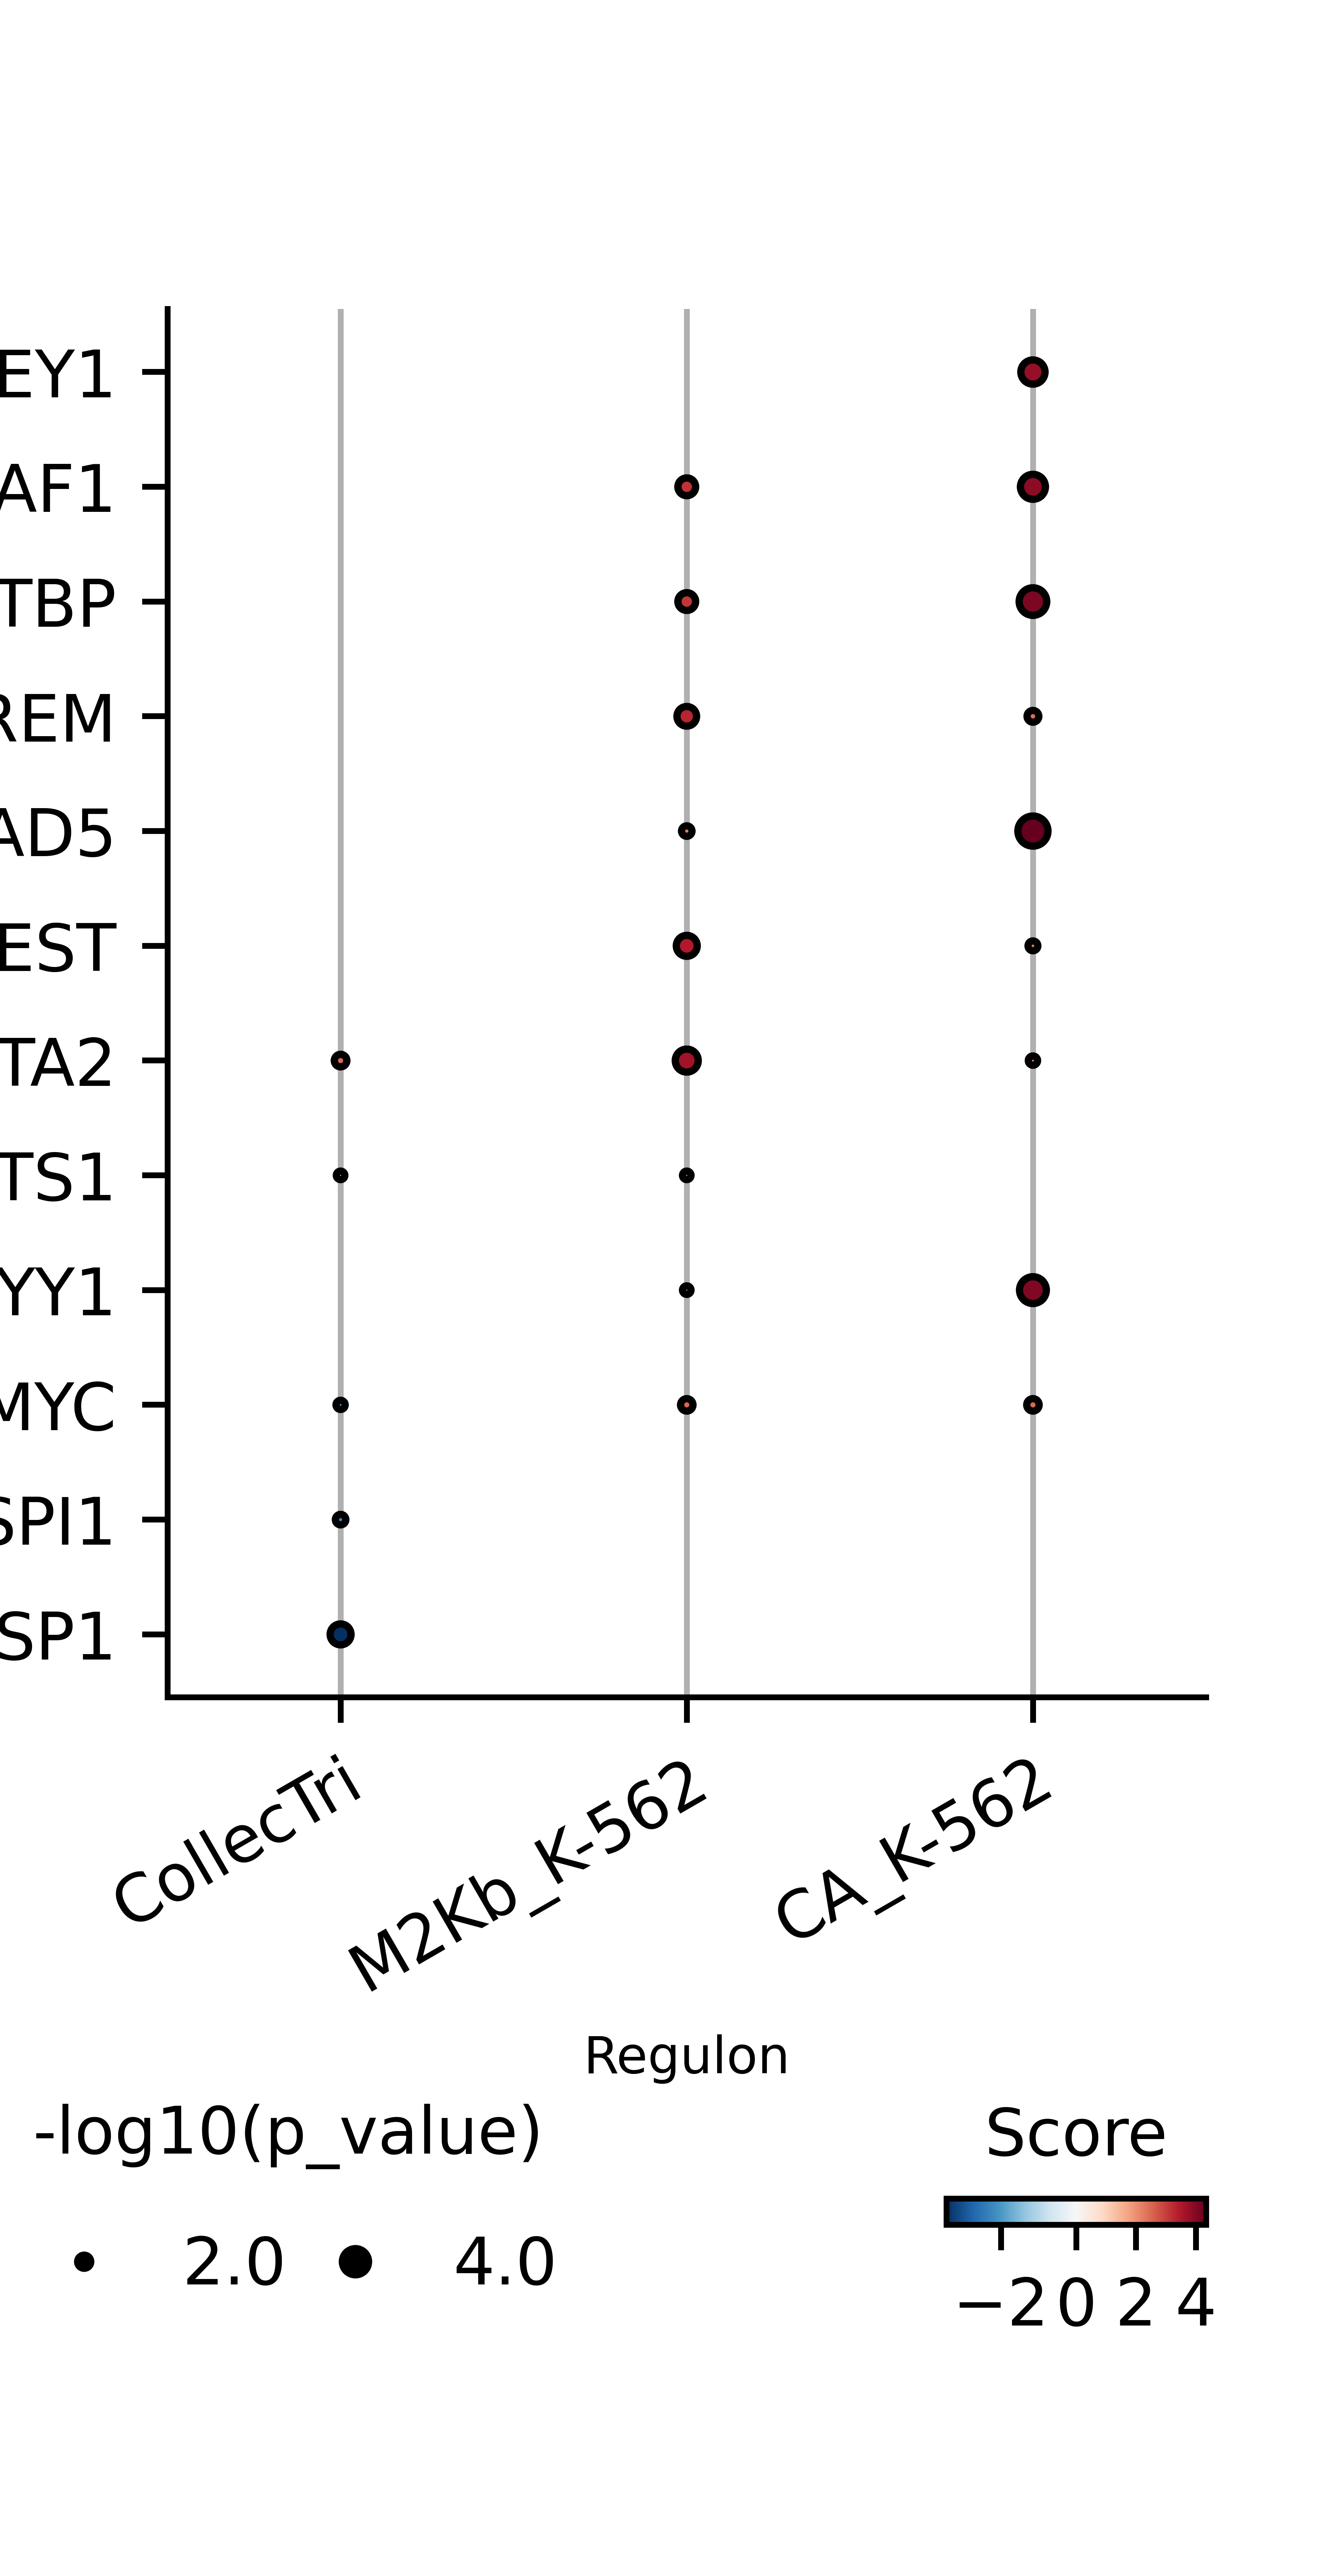

In [237]:
plt.close()
out = pd.DataFrame()
interesting_tf = []#"SPI1", "ELF1", "SP1", "TRIM28", "CC2D1A", "PLAG1", "PHF8", "HEY1", "E2F1", "EZH2", "YY1", "RREB1", "FOXJ2", "ZNF148", "UBTF"]
mask = []
for net in ["CollecTri", "M2Kb_K-562", "CA_K-562"]:
    mask = megaheat_sc[megaheat_sc.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat_sc.loc[megaheat_sc.TF.isin(mask) | megaheat_sc.TF.isin(interesting_tf), :]])
#|out.TF = pd.Categorical(out.TF, categories=interesting_tf, ordered=True)
plot_bubbles(out, scale=0.15)
plt.savefig("../plots/3-tf_activity/aml_activity_clustermap_hsc_k562_sc.svg", dpi=720, format="svg")
plt.show()

In [238]:
len(megaheat_sc[megaheat_sc.Network == "CollecTri"].index.to_list())

5

In [239]:
print(", ".join(megaheat_sc[megaheat_sc.Network == "M2Kb_K-562"].index.to_list()))

YY1, PLAG1, RLF, TRIM24, ETS1, SKIL, ARID3B, CC2D1A, BHLHE40, NONO, NR2F2, BCOR, EGR1, CREB1, GFI1B, SOX6, BRD4, MTA3, NR4A1, FOXM1, CTCFL, ZNF148, SMAD5, MBD2, SMARCE1, MTA2, TCF3, KDM5B, NCOR1, SAP30, ASH1L, STAT5A, NRF1, PBX2, ZNF24, NR3C1, E2F6, MYC, GABPA, GATA1, SIN3A, TAL1, SMARCA4, RB1, CTCF, TRIM28, ARID3A, E2F1, UBTF, HDAC1, TBP, TAF1, CREM, REST, GATA2


In [240]:
print(", ".join(megaheat_sc[megaheat_sc.Network == "CollecTri"].index.to_list()))

SP1, SPI1, MYC, ETS1, GATA2


In [241]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list()))

KAT2B, ZNF77, ETS1, CTCF, HDAC1, PML, FOXM1, KLF16, NR3C1, GATA2, IRF1, BHLHE40, NFATC3, SAP30, ZBTB7A, ATF2, MNT, SIN3A, REST, ATF1, CREB1, TRIM28, E2F1, CC2D1A, PLAG1, PHF8


In [242]:
print(", ".join(megaheat[megaheat.Network == "CollecTri"].index.to_list()))

SPI1, ELF1, SP1, HEY1, RFX5, CREM, CTNNB1, IRF1, CREBBP, IKZF1, LEF1, NR3C1, IRF2, GATA2, ELK1, CREB1, NFATC3, E2F1, KLF1, NFIC, NFE2, EZH2


In [243]:
enr = gp.enrich(megaheat_sc[megaheat_sc.Network == "CollecTri"].index.to_list(), "KEGG_2021_Human")
print(enr.results.head(5))
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_collectri_hsc_sc.tsv", sep="\t", index=False)

          Gene_set                                     Term Overlap   P-value  \
0  KEGG_2021_Human                       Pathways in cancer   4/531  0.000002   
1  KEGG_2021_Human  Transcriptional misregulation in cancer   3/192  0.000009   
2  KEGG_2021_Human  Human T-cell leukemia virus 1 infection   3/219  0.000013   
3  KEGG_2021_Human                   Acute myeloid leukemia    2/67  0.000110   
4  KEGG_2021_Human               TGF-beta signaling pathway    2/94  0.000217   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000111            0                     0  147.764706   
1          0.000195            0                     0  157.190476   
2          0.000195            0                     0  137.354167   
3          0.001263            0                     0  204.410256   
4          0.001992            0                     0  144.224638   

   Combined Score              Genes  
0     1911.761811  SPI1;SP1;MYC;ETS1  
1     1833.662

In [244]:
enr = gp.enrich(megaheat_sc[megaheat_sc.Network == "M2Kb_K-562"].index.to_list(), "KEGG_2021_Human")
print(enr.results.head(5))
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_m2kb_k562_hsc_sc.tsv", sep="\t", index=False)

          Gene_set                                               Term Overlap  \
0  KEGG_2021_Human            Human T-cell leukemia virus 1 infection   9/219   
1  KEGG_2021_Human                           Chronic myeloid leukemia    5/76   
2  KEGG_2021_Human                       Epstein-Barr virus infection   6/202   
3  KEGG_2021_Human  Signaling pathways regulating pluripotency of ...   5/143   
4  KEGG_2021_Human                                Cellular senescence   5/156   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  7.886926e-09      7.177103e-07            0                     0   
1  2.079384e-06      9.461196e-05            0                     0   
2  1.892157e-05      5.739542e-04            0                     0   
3  4.545618e-05      1.034128e-03            0                     0   
4  6.876633e-05      1.246954e-03            0                     0   

   Odds Ratio  Combined Score                                         Genes  
0 